<a href="https://colab.research.google.com/github/lamakye7/Deposit_Term_Subcription/blob/main/Azubi_African_Louis_Amakye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Azubi Africa: Talent Mobility Program**

> **Project Title:** Predicting Subcription of Marketing Campaign<br>
> **Name:** Louis Amakye <br>
> **LinkedIN:** https://www.linkedin.com/in/
louis-amakye-34358816b/<br>
> **Email:** louisamakye20@gmail.com

## Table of Contents

* [Pace Stages](#ps)
* [Problem Statement](#pace)
    * [Problem Statement](#ps)
    * [Hypothesis](#hs)
    * [Project Goal](#pg)
* [Exploratory Data Analysis (EDA)](#pace1)  
* [Preprocessing and Feature Engineering](#con)
* [Model Building and Evaluation](#con)     
* [Key Findings and Insights](#cr)
* [Reference](#r)

## 1.0  **Pace: Plan** <a id='pace'></a>


## 1.1 Business Problem Understanding<a id='bp'></a>

The banking institution faces the challenge of optimizing their direct marketing campaigns for term deposit subscriptions, where success requires understanding which clients are most likely to respond positively to phone-based outreach. With multiple contacts often needed per client, the bank must efficiently allocate resources and identify the optimal timing and frequency of calls to maximize conversion rates while minimizing costs. The current approach lacks data-driven insights into client characteristics, campaign timing, and contact strategies that lead to successful term deposit subscriptions. By analyzing historical campaign data, the bank can develop predictive models to improve targeting accuracy, reduce unnecessary contacts, and ultimately increase the return on investment for their marketing efforts.



### 1.2 Hypothesis <a id='hs'></a>

<p style="text-align:justify;">It is possible to predict that whether or not client  will subscribe to deposit term</p>

### 1.3 Project Goal <a id='pg'></a>

<p style="text-align:justify;">In this project, to achieve the following;</p>

* __Actionable Insights to help the campaign team__
  1. Which client demographics (`age`, `job`, `marital `status`, `education`) are most consistently associated with subscribing to a term deposit, and how can we leverage these insights to target future campaigns more effectively?
  2. What is the optimal contact strategy in terms of communication type, duration, and number of contacts within a campaign to maximize term deposit subscriptions, while minimizing wasted effort on unproductive calls?

  3. How do previous campaign outcomes and the time since the last contact (`pdays`) influence a client's likelihood of subscribing to a term deposit in the current campaign, and can this information be used for more intelligent lead scoring?
  4. Are there specific combinations of housing and personal loan statuses (`housing`, `loan`) and credit default (`default`) that significantly impact term deposit subscription rates, and how should these financial attributes be considered when approaching clients?



* __Machine Learning Model to predict the likelywood of subcription__

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [122]:
!pip install --upgrade shap

# 2 Exploratory Data Analysis

## Step 1. Imports<a id='st1'></a>

*   Import packages
*   Load dataset



### Import packages<a id='ip'></a>

In [2]:
# Import packages
# For data manipulation
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.contingency_tables import Table2x2
from scipy.stats import chi2_contingency
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
%matplotlib inline

from scipy.stats import chi2_contingency, fisher_exact
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows", 150)
sns.set_style("darkgrid")
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] =(12,8)
plt.rcParams["figure.facecolor"] = "#00000000"

# For data modeling

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_sample_weight
import shap

# For metrics and preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
# For saving models
import pickle

### Load dataset<a id='ld'></a>

In [3]:
import xgboost
xgboost.__version__

'2.1.4'

In [4]:
def fix_merged_columns(df, column_index=0, separator=';'):
    """
    function to split merged columns
    """
    # Get the column name
    col_name = df.columns[column_index]

    # Get the column as a Series
    column_series = df.iloc[:, column_index]

    # Convert everything to string
    try:
        # Direct conversion
        string_series = column_series.astype(str)
        print("✓ Successfully converted to string")
    except Exception as e:
        print(f"✗ Error converting to string: {e}")
        return None

    try:
        # Manual splitting approach
        all_rows = []
        headers = None

        for idx, value in string_series.items():
            if pd.isna(value) or str(value).strip() == '':
                continue

            # Split the value
            split_parts = str(value).split(separator)

            # Clean each part
            clean_parts = [part.strip().replace('"', '') for part in split_parts]

            # First row with data becomes headers
            if headers is None:
                if separator in col_name:
                    # Headers are in column name
                    headers = [h.strip().replace('"', '') for h in col_name.split(separator)]
                    all_rows.append(clean_parts)
                else:
                    # First row is headers
                    headers = clean_parts
                    continue
            else:
                all_rows.append(clean_parts)


        # Create DataFrame
        max_cols = len(headers)
        padded_rows = []

        for row in all_rows:
            if len(row) < max_cols:
                # Pad with empty strings
                row.extend([''] * (max_cols - len(row)))
            elif len(row) > max_cols:
                # Truncate
                row = row[:max_cols]
            padded_rows.append(row)

        # Create the new DataFrame
        new_df = pd.DataFrame(padded_rows, columns=headers)

        # Convert numeric columns
        for col in new_df.columns:
            # Try to convert to numeric
            new_df[col] = pd.to_numeric(new_df[col], errors="ignore")


        return new_df

    except Exception as e:
        print(f"✗ Error in splitting process: {e}")
        import traceback
        traceback.print_exc()
        return None

In [5]:
def load_and_format_data(file_path="/content/drive/MyDrive/Azubi Africa/bank-full.csv"):
  df = pd.read_csv(file_path)
  df_fixed = fix_merged_columns(df)
  return df_fixed

In [6]:
# load bank-full.csv
df =load_and_format_data()

✓ Successfully converted to string


<ipython-input-4-c8c7f420543f>:68: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  new_df[col] = pd.to_numeric(new_df[col], errors="ignore")


In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Gather basic information about the data

In [ ]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Gather descriptive statistics about the data

In [ ]:
# Gather descriptive statistics about the data
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
# Display all column names
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [8]:
def unique_values(df):
    # Select categorical columns and exclude 'loan_id' and 'customer_id'
    cat = [col for col in df.select_dtypes(include=['object']).columns]

    # Check if there are categorical columns to process
    if not cat:
        print("No categorical columns found.")
        return
    # Loop through the categorical columns and print unique values
    for feature in cat:
        print(f"The unique values in '{feature}' are: {df[feature].unique()}")


In [9]:
unique_values(df)

The unique values in 'job' are: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
The unique values in 'marital' are: ['married' 'single' 'divorced']
The unique values in 'education' are: ['tertiary' 'secondary' 'unknown' 'primary']
The unique values in 'default' are: ['no' 'yes']
The unique values in 'housing' are: ['yes' 'no']
The unique values in 'loan' are: ['no' 'yes']
The unique values in 'contact' are: ['unknown' 'cellular' 'telephone']
The unique values in 'month' are: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
The unique values in 'poutcome' are: ['unknown' 'failure' 'other' 'success']
The unique values in 'y' are: ['no' 'yes']


In [ ]:
def value_distribution(df):
    # Select categorical columns and exclude 'loan_id' and 'customer_id'
    cat = [col for col in df.select_dtypes(include=['object']).columns]

    # Check if there are categorical columns to process
    if not cat:
        print("No categorical columns found.")
        return
    # Loop through the categorical columns and print unique values
    for feature in cat:
        print(f"The distribution for {feature} are:")
        print(df[feature].value_counts())


In [ ]:
value_distribution(df)

The distribution for job are:
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
The distribution for marital are:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
The distribution for education are:
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
The distribution for default are:
default
no     44396
yes      815
Name: count, dtype: int64
The distribution for housing are:
housing
yes    25130
no     20081
Name: count, dtype: int64
The distribution for loan are:
loan
no     37967
yes     7244
Name: count, dtype: int64
The distribution for contact are:
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64
The d

### Check missing values

Check for any missing values in the data.

In [ ]:
# Check for missing values
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


There are no missing values in the data.

### Check duplicates

Check for any duplicate entries in the data.

In [10]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [11]:
# Inspect some rows containing duplicates as needed
df[df.duplicated()].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


The above output shows that there are no duplicates in the data

### Check outliers

Check for outliers in the data.

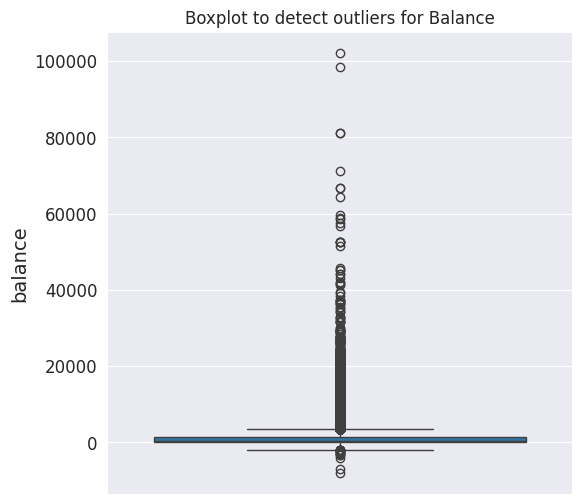

In [ ]:
# Create a boxplot to visualize distribution of 'balance any outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for Balance', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(df['balance'])
plt.show()

In [12]:
# Compute the 25th percentile value in 'balance
percentile25 = df['balance'].quantile(0.25)

# Compute the 75th percentile value in 'balance
percentile75 = df['balance'].quantile(0.75)

# Compute the interquartile range in 'balance
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in balance
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in 'balance
outliers = df[(df['balance'] > upper_limit) | (df['balance'] < lower_limit)]

# Count how many rows in the data contain outliers in 'balance
print("Number of rows in the data containing outliers in `balance`:", len(outliers))

Lower limit: -1962.0
Upper limit: 3462.0
Number of rows in the data containing outliers in `balance`: 4729


The boxplot and iqr above shows that there are no outliers in the `balance` variable.



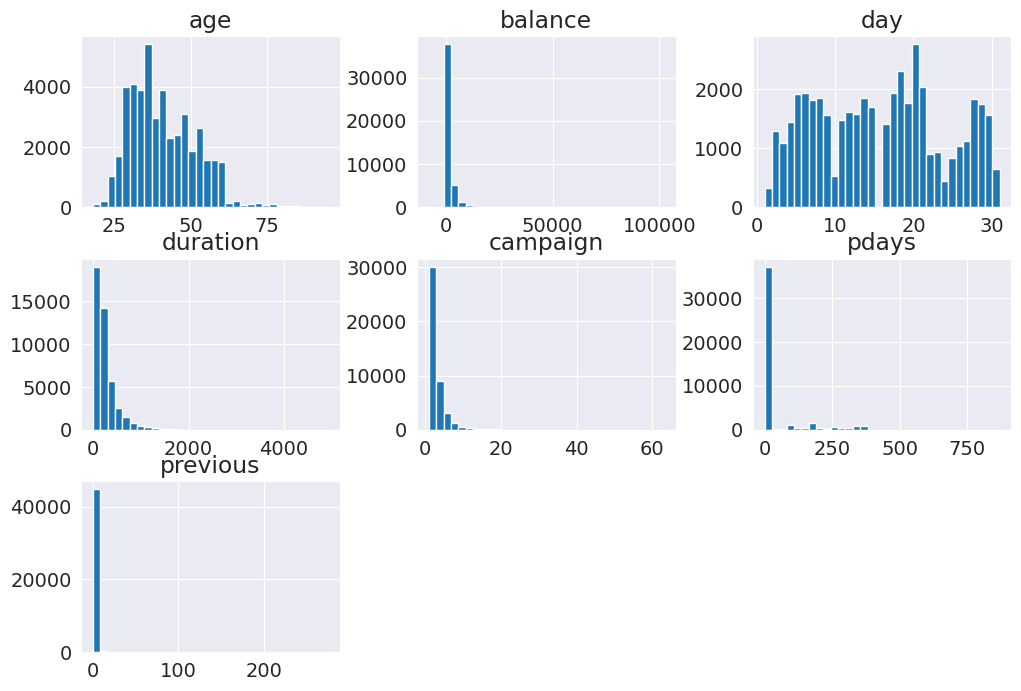

In [13]:
# plot histogram for catgoricals
df.hist(bins=32, figsize=(12,8))
plt.show()

from the plot above
* age: Appears to be a roughly normal or slightly right-skewed distribution, with a peak around 30-40 years old and a tail extending towards older ages.

* balance: Highly right-skewed, with a large concentration of values near zero and a long tail extending towards higher balances. This indicates most accounts have low balances, and a few have very high balances.
* day: Shows a relatively uniform distribution across the days of the month, with some fluctuations. There isn't a strong peak or clear skew.
* duration: Highly right-skewed, with most durations being very short and a long tail indicating a few very long durations.
* campaign: Highly right-skewed, with most observations having a low number of campaigns and a long tail indicating a few instances with a very high number of campaigns.
* pdays: Highly right-skewed, with a significant concentration of values at zero (or very low values) and a long tail extending to higher 'pdays' values. This suggests many individuals have not been contacted recently (or at all in a previous campaign), while a few have.

In [14]:
# function to plot piechart
def plot_pie_chart(df, col='y'):
  # Count the occurrences of each group
  group_counts = df1[col].value_counts()

  plt.figure(figsize=(8, 6))
  group_counts.plot.pie(autopct='%1.1f%%', startangle=90)
  plt.ylabel('')
  plt.title('Distribution of Clients')


In [15]:
# bucket features
def bucket_features(df):
    """
    function to create new features
    """
    df = df.copy()
    # Bin credit_score using the Fico Model
    bins = [18, 27, 43, 59, 100]
    labels = ['Gen Z (18-27)', 'Millennials (28-43)',
              'Gen X (44-59)', 'Baby Boomers (60+)']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)
    # Decode loan_default
    df['y_encoded'] = df['y'].apply(lambda x: 1 if x == "yes" else 0)
    df['y'] = df['y'].apply(lambda x: 'Subscription' if x == "yes" else 'No_Subscription')
    df['housing'] = df['housing'].apply(lambda x: 'Mortgage' if x == "yes" else 'No_Mortgage')
    df['pdays_group'] = df['pdays'].apply(lambda x: 'Not Contacted' if x == -1 else 'Contacted')

    return df
#
df1 = bucket_features(df)

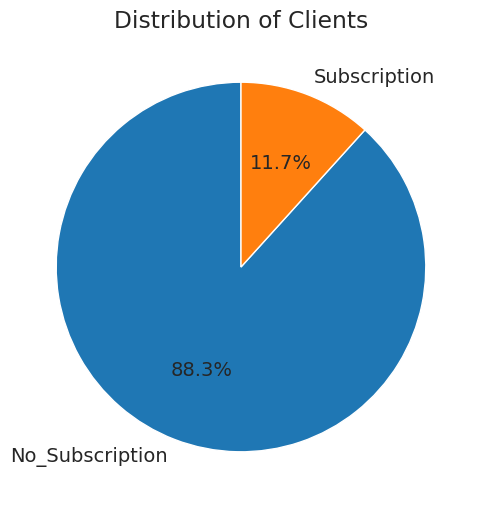

In [16]:
# piechart for for subcription type
plot_pie_chart(df1)


### To achieve the first goal, we will try to answer the questions listed below:

The actionable questions below




### __1. Which client demographics (`age`, `job`, `marital` `status`, `education`) are most consistently associated with subscribing to a term deposit, and how can we leverage these insights to target future campaigns more effectively?__

In [ ]:
df1.column

In [ ]:
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [96]:
def individual_attribute_analysis(df):
    """
    Analyze each Demograghic attribute individually
    """
    attributes = ['age_group', 'job', 'marital', 'education']
    individual_results = {}

    for attr in attributes:
        print(f"\n{attr.upper()} Demograghic IMPACT:")
        print("-" * 25)

        # Calculate subscription rates
        attr_analysis = df.groupby(attr, observed=True).agg({
            'y_encoded': ['sum', 'count', 'mean'],
            'balance': 'mean'
        }).round(3)

        attr_analysis.columns = ['Subscriptions', 'Total_Clients', 'Success_Rate', 'Avg_Balance']
        attr_analysis['Success_Rate_Pct'] = attr_analysis['Success_Rate'] * 100

        print(attr_analysis[['Subscriptions', 'Total_Clients', 'Success_Rate_Pct', 'Avg_Balance']])





In [97]:
individual_attribute_analysis(df1)


AGE_GROUP Demograghic IMPACT:
-------------------------
                     Subscriptions  Total_Clients  Success_Rate_Pct  \
age_group                                                             
Gen Z (18-27)                  595           3050              19.5   
Millennials (28-43)           2696          25361              10.6   
Gen X (44-59)                 1398          15016               9.3   
Baby Boomers (60+)             600           1784              33.6   

                     Avg_Balance  
age_group                         
Gen Z (18-27)            989.490  
Millennials (28-43)     1220.108  
Gen X (44-59)           1547.843  
Baby Boomers (60+)      2458.619  

JOB Demograghic IMPACT:
-------------------------
               Subscriptions  Total_Clients  Success_Rate_Pct  Avg_Balance
job                                                                       
admin.                   631           5171              12.2     1135.839
blue-collar              708  

In [108]:
def create_visualizations(df):
    """
    Create visualizations for the analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # 1. Subscription rate by previous outcome
    age_group_rates = df.groupby('age_group')['y'].apply(lambda x: (x == 'Subscription').mean() * 100)
    age_group_rates.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Subscription Rate by Age Group')
    axes[0,0].set_ylabel('Success Rate (%)')
    axes[0,0].tick_params(axis='x', rotation=45)

    # # 2. Distribution of pdays (excluding -1)
    # education_rates = df.groupby('education')['y'].apply(lambda x: (x == 'Subscription').mean() * 100)
    # education_rates.plot(kind='bar', ax=axes[0,1], color='skyblue')
    # axes[0,1].set_title('Subscription Rate by Education')
    # axes[0,1].set_ylabel('Success Rate (%)')
    # axes[0,1].tick_params(axis='x', rotation=45)

     # 2. Heatmap
    pivot_data = df.groupby(['marital', 'job'])['y'].apply(
        lambda x: (x == 'Subscription').mean() * 100
    ).unstack(fill_value=0)
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0,1])
    axes[0,1].set_title('Success Rate Heatmap: Age group vs Education')


    # 3. Heatmap
    pivot_data = df.groupby(['age_group', 'education'])['y'].apply(
        lambda x: (x == 'Subscription').mean() * 100
    ).unstack(fill_value=0)
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1,0])
    axes[1,0].set_title('Success Rate Heatmap: Age group vs Education')

    # 4. Heatmap of combined effect

    pivot_data = df.groupby(['age_group', 'marital'])['y'].apply(
        lambda x: (x == 'Subscription').mean() * 100
    ).unstack(fill_value=0)

    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1,1])
    axes[1,1].set_title('Success Rate Heatmap: Age group vs Job')

    plt.tight_layout()
    plt.show()

<ipython-input-108-886ecc57641c>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_rates = df.groupby('age_group')['y'].apply(lambda x: (x == 'Subscription').mean() * 100)
<ipython-input-108-886ecc57641c>:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_data = df.groupby(['age_group', 'education'])['y'].apply(
<ipython-input-108-886ecc57641c>:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_data = 

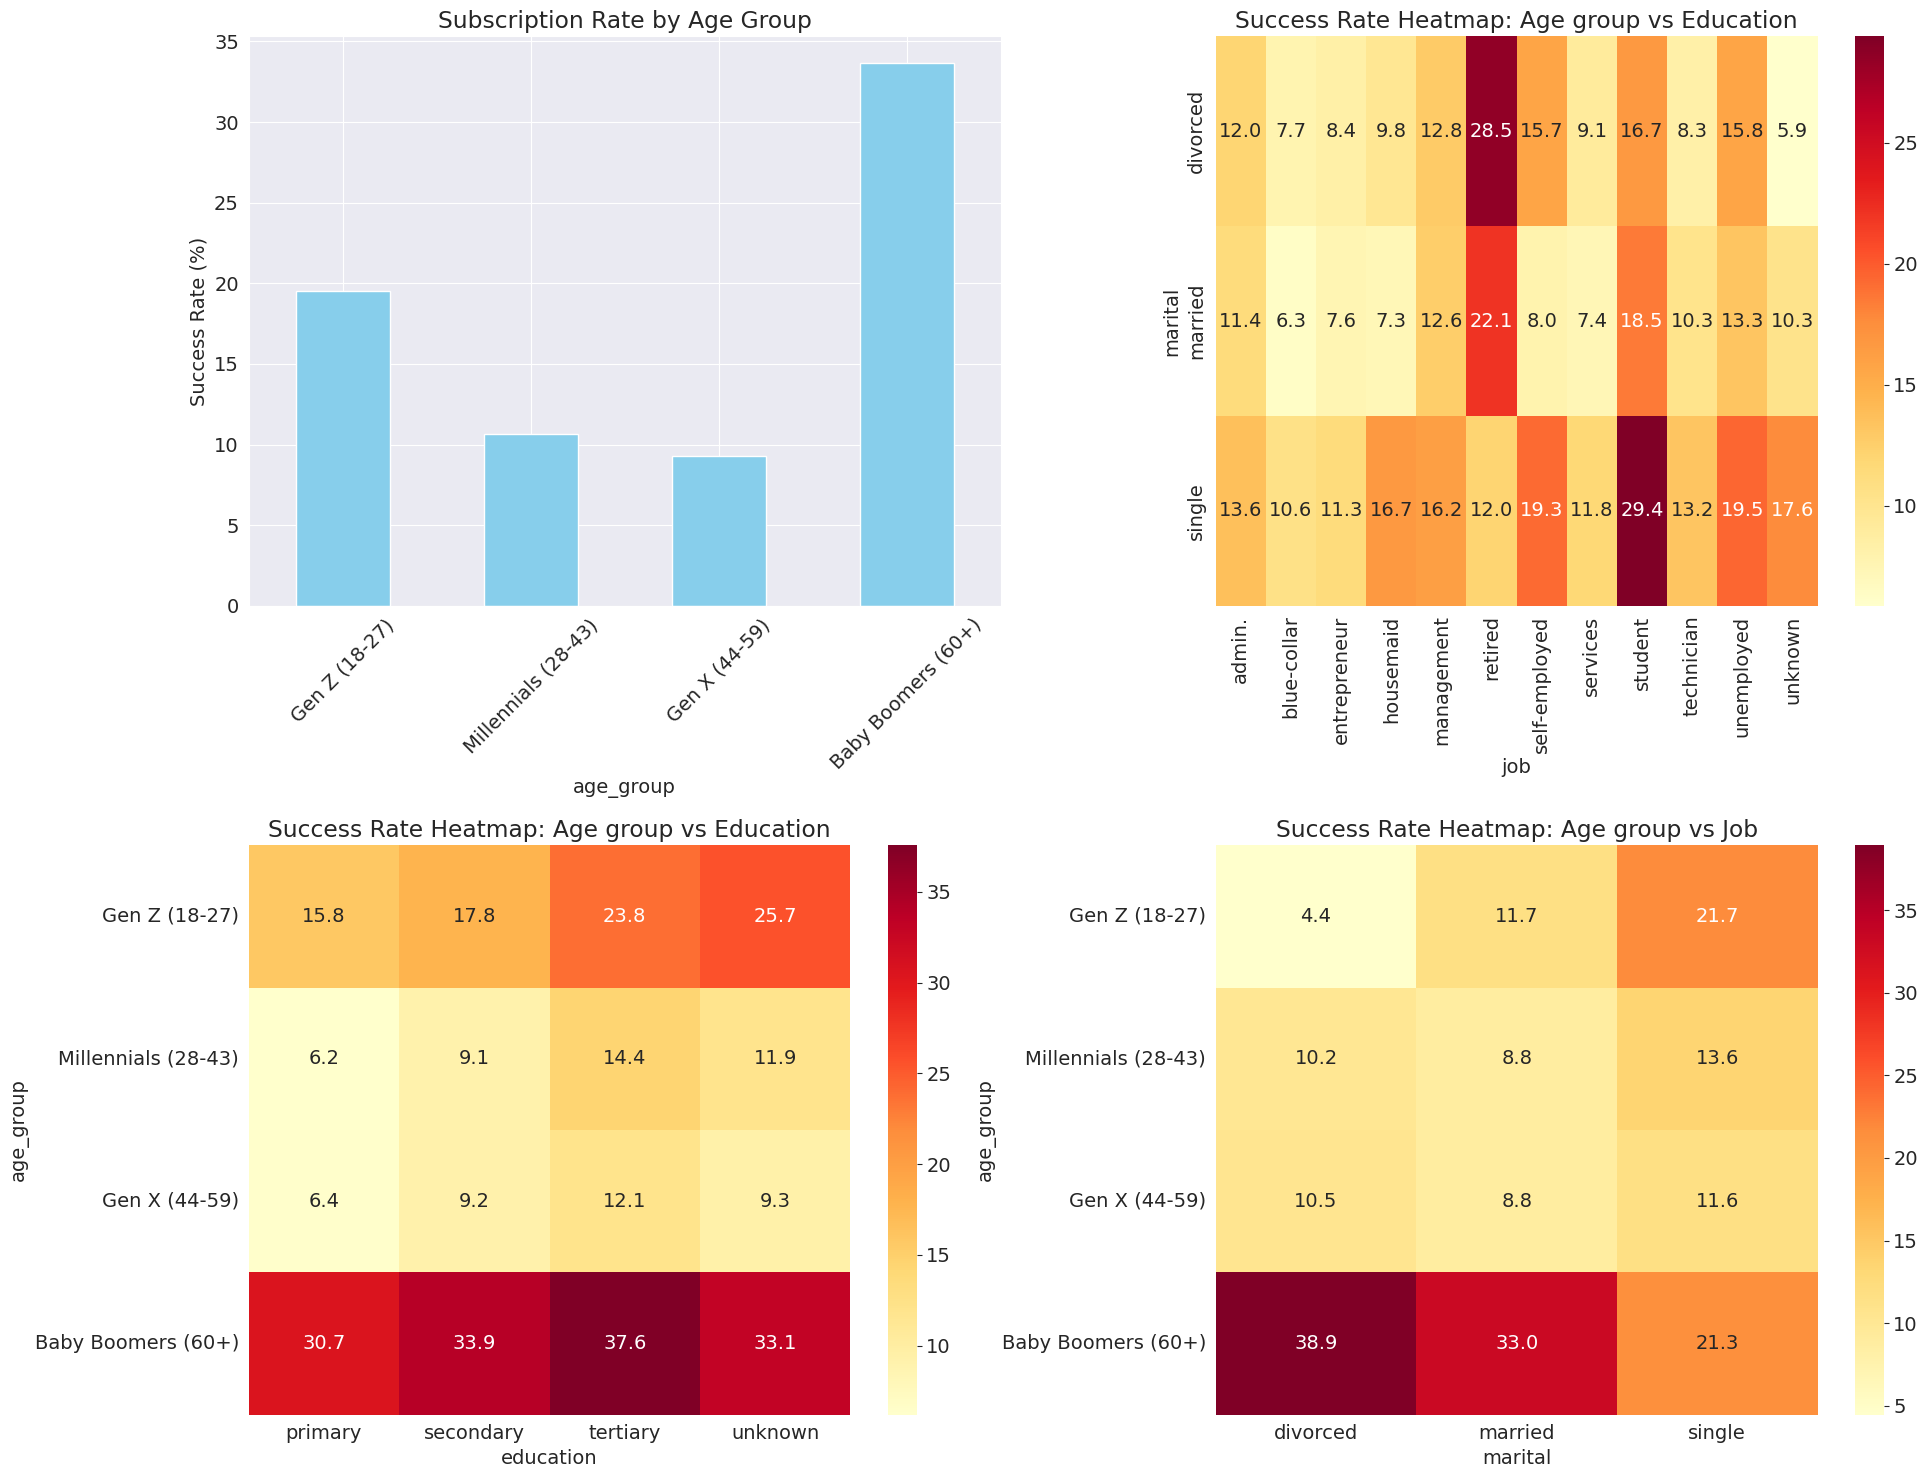

In [109]:
create_visualizations(df1)

--- Summary of Findings for Targeting ---

Based on the above analysis:

Age: Clients in age group Baby Boomers (60+), Gen Z (18-27) and Millennials (28-43) are more receptive.

Job: Student has high subcription rate as compared to other job category followed by retired group

Education and Marital: More focus should be on tertiary and single group

Boomers with tertiary education level has highest rate through combination of age group and education level

Boomers who are divorced has hightest rate comparing age group and marital status

Single student group and divorced retired has higher rate of 29% and 28% respectively comparing job and marital statuse


### __2. What is the optimal contact strategy in terms of communication type, duration, and number of contacts within a campaign to maximize term deposit subscriptions, while minimizing wasted effort on unproductive calls?__

#### Analysis for Contact Communication Type

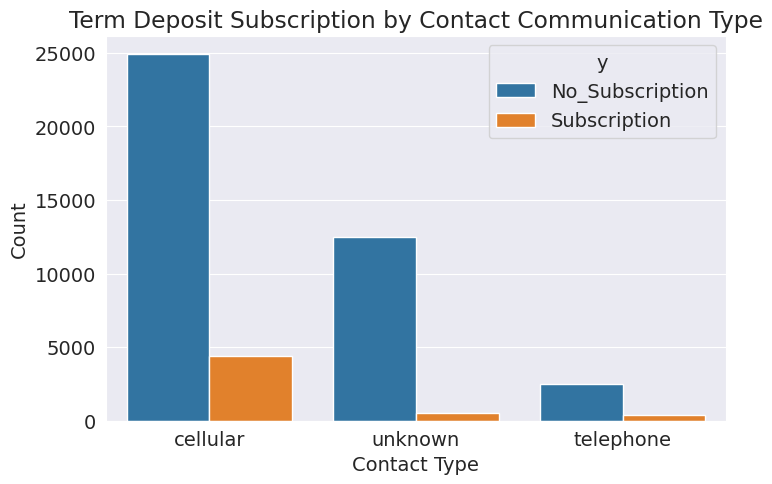

In [32]:
# --- Analysis for Contact Communication Type ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='contact', hue='y', order=df1['contact'].value_counts().index)
plt.title('Term Deposit Subscription by Contact Communication Type')
plt.xlabel('Contact Type')
plt.ylabel('Count')
plt.show()


In [33]:
# Calculate subscription rate by contact type
contact_subscription_rate = df1.groupby('contact')['y_encoded'].mean().sort_values(ascending=False)
print("\nTerm Deposit Subscription Rate by Contact Type:")
print(contact_subscription_rate)


Term Deposit Subscription Rate by Contact Type:
contact
cellular     0.149189
telephone    0.134205
unknown      0.040707
Name: y_encoded, dtype: float64


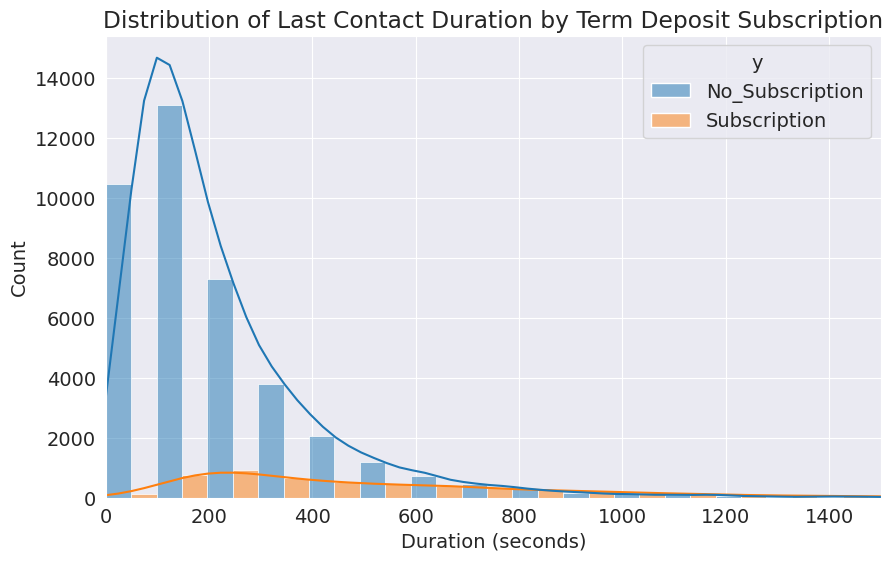

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df1, x='duration', hue='y', bins=50, multiple='dodge', kde=True, common_norm=False)
plt.title('Distribution of Last Contact Duration by Term Deposit Subscription')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.xlim(0, 1500)
plt.show()

Highly right-skewed, with most durations being very short and a long tail indicating a few very long durations.

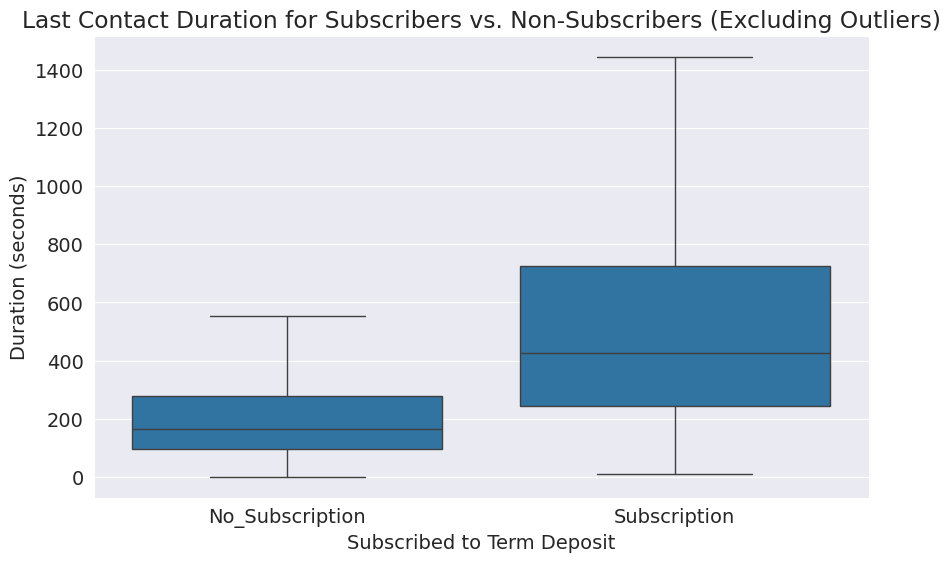

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df1, x='y', y='duration', showfliers=False)
plt.title('Last Contact Duration for Subscribers vs. Non-Subscribers (Excluding Outliers)')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Duration (seconds)')
plt.show()

In [36]:
# Calculate mean and median duration for subscribers and non-subscribers
duration_stats = df1.groupby('y')['duration'].agg(['mean', 'median'])
print("\nLast Contact Duration Statistics (Mean and Median by Subscription):")
print(duration_stats)



Last Contact Duration Statistics (Mean and Median by Subscription):
                       mean  median
y                                  
No_Subscription  221.182806   164.0
Subscription     537.294574   426.0


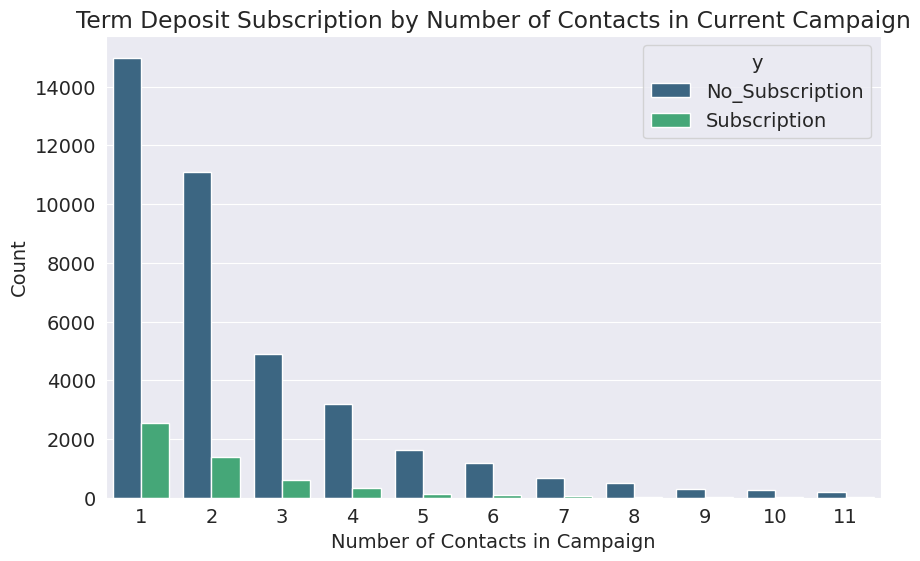

In [37]:
#Analysis for Number of Contacts during this Campaign
plt.figure(figsize=(10, 6))
sns.countplot(data=df1, x='campaign', hue='y', palette='viridis')
plt.title('Term Deposit Subscription by Number of Contacts in Current Campaign')
plt.xlabel('Number of Contacts in Campaign')
plt.ylabel('Count')
plt.xlim(-0.5, 10.5) # Focus on reasonable number of contacts
plt.xticks(range(0, 11))
plt.show()

In [38]:
# Calculate subscription rate by number of contacts in campaign
campaign_subscription_rate = df1.groupby('campaign')['y_encoded'].mean().sort_values(ascending=False)
print("\nTerm Deposit Subscription Rate by Number of Contacts in Current Campaign:")
print(campaign_subscription_rate.head(10)) # Display top 10 for brevity


Term Deposit Subscription Rate by Number of Contacts in Current Campaign:
campaign
1     0.145976
2     0.112035
3     0.111936
32    0.111111
4     0.090006
17    0.086957
11    0.079602
5     0.078798
6     0.071263
9     0.064220
Name: y_encoded, dtype: float64


from the above boxplot higher duration with client seem more reception

### __3. How do previous campaign outcomes and the time since the last contact (pdays) influence a client's likelihood of subscribing to a term deposit in the current campaign, and can this information be used for more intelligent lead scoring?__

#### Analysis for Outcome of Previous Marketing Campaign (poutcome)

In [39]:
df1["y"].unique()

array(['No_Subscription', 'Subscription'], dtype=object)

In [40]:
# Basic statistics on pdays and poutcome
print("BASIC STATISTICS")
print("-" * 40)
print(f"Clients never contacted before (pdays = -1): {(df1['pdays'] == -1).sum():,} ({(df1['pdays'] == -1).mean()*100:.1f}%)")
print(f"Clients with previous contact: {(df1['pdays'] != -1).sum():,} ({(df1['pdays'] != -1).mean()*100:.1f}%)")
print("\nPrevious outcome distribution:")
print(df['poutcome'].value_counts())
print(f"\nOverall subscription rate: {df1['y'].value_counts()['Subscription'] / len(df1) * 100:.2f}%")

BASIC STATISTICS
----------------------------------------
Clients never contacted before (pdays = -1): 36,954 (81.7%)
Clients with previous contact: 8,257 (18.3%)

Previous outcome distribution:
poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

Overall subscription rate: 11.70%


In [41]:
# Subscription rates by previous outcome
print("SUBSCRIPTION RATES BY PREVIOUS OUTCOME")
print("-" * 50)
poutcome_analysis = df1.groupby('poutcome')['y_encoded'].agg([
    lambda x: (x == 1).sum(),  # count of yes
    'count',  # total count
    lambda x: (x == 1).mean() * 100  # percentage
]).round(2)
poutcome_analysis.columns = ['Subscriptions', 'Total_Contacts', 'Success_Rate_%']
print(poutcome_analysis)

SUBSCRIPTION RATES BY PREVIOUS OUTCOME
--------------------------------------------------
          Subscriptions  Total_Contacts  Success_Rate_%
poutcome                                               
failure             618            4901           12.61
other               307            1840           16.68
success             978            1511           64.73
unknown            3386           36959            9.16


In [42]:
# Analyze pdays impact (excluding -1 values)
print("PDAYS IMPACT ANALYSIS")
print("-" * 35)

# Create pdays categories for better analysis
df_contacted = df1[df1['pdays'] != -1].copy()
if len(df_contacted) > 0:
    df_contacted['pdays_category'] = pd.cut(
        df_contacted['pdays'],
        bins=[-1, 30, 90, 180, 365, float('inf')],
        labels=['0-30 days', '31-90 days', '91-180 days', '181-365 days', '366+ days']
    )

    pdays_analysis = df_contacted.groupby('pdays_category')['y_encoded'].agg([
        lambda x: (x == 1).sum(),
        'count',
        lambda x: (x == 1).mean() * 100
    ]).round(2)
    pdays_analysis.columns = ['Subscriptions', 'Total_Contacts', 'Success_Rate_%']
    print(pdays_analysis)

PDAYS IMPACT ANALYSIS
-----------------------------------
                Subscriptions  Total_Contacts  Success_Rate_%
pdays_category                                               
0-30 days                  28             188           14.89
31-90 days                223             530           42.08
91-180 days               680            2480           27.42
181-365 days              786            4416           17.80
366+ days                 188             643           29.24


<ipython-input-42-804b2da78d51>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdays_analysis = df_contacted.groupby('pdays_category')['y_encoded'].agg([


In [43]:
# Combined analysis: poutcome + pdays categories
print("COMBINED ANALYSIS: POUTCOME + TIME SINCE CONTACT")
print("-" * 60)

# For clients with previous contact
if len(df_contacted) > 0:
    combined_analysis = df_contacted.groupby(['poutcome', 'pdays_category'])['y_encoded'].agg([
        lambda x: (x == 1).sum(),
        'count',
        lambda x: (x == 1).mean() * 100
    ]).round(2)
    combined_analysis.columns = ['Subscriptions', 'Total_Contacts', 'Success_Rate_%']
    print(combined_analysis)

COMBINED ANALYSIS: POUTCOME + TIME SINCE CONTACT
------------------------------------------------------------
                         Subscriptions  Total_Contacts  Success_Rate_%
poutcome pdays_category                                               
failure  0-30 days                10.0              48           20.83
         31-90 days               67.0             247           27.13
         91-180 days             188.0            1385           13.57
         181-365 days            252.0            2793            9.02
         366+ days               101.0             428           23.60
other    0-30 days                 5.0             110            4.55
         31-90 days               35.0              95           36.84
         91-180 days             101.0             479           21.09
         181-365 days            132.0            1019           12.95
         366+ days                34.0             137           24.82
success  0-30 days                13.0

<ipython-input-43-7eb4e42f2c86>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_analysis = df_contacted.groupby(['poutcome', 'pdays_category'])['y_encoded'].agg([


In [47]:
def create_visualizations(df):
    """
    Create visualizations for the analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Subscription rate by previous outcome
    poutcome_rates = df.groupby('poutcome')['y'].apply(lambda x: (x == 'Subscription').mean() * 100)
    poutcome_rates.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Subscription Rate by Previous Campaign Outcome')
    axes[0,0].set_ylabel('Success Rate (%)')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Distribution of pdays (excluding -1)
    df_contacted = df[df['pdays'] != -1]
    if len(df_contacted) > 0:
        axes[0,1].hist(df_contacted['pdays'], bins=50, alpha=0.7, color='lightcoral')
        axes[0,1].set_title('Distribution of Days Since Previous Contact')
        axes[0,1].set_xlabel('Days')
        axes[0,1].set_ylabel('Frequency')

    # 3. Success rate by pdays categories
    if len(df_contacted) > 0:
        df_contacted['pdays_category'] = pd.cut(
            df_contacted['pdays'],
            bins=[-1, 30, 90, 180, 365, 730, float('inf')],
            labels=['0-30', '31-90', '91-180', '181-365', '366-730', "730+"]
        )
        pdays_rates = df_contacted.groupby('pdays_category')['y'].apply(lambda x: (x == 'Subscription').mean() * 100)
        pdays_rates.plot(kind='bar', ax=axes[1,0], color='lightgreen')
        axes[1,0].set_title('Success Rate by Days Since Previous Contact')
        axes[1,0].set_ylabel('Success Rate (%)')
        axes[1,0].tick_params(axis='x', rotation=0)

    # 4. Heatmap of combined effect
    if len(df_contacted) > 0:
        pivot_data = df_contacted.groupby(['poutcome', 'pdays_category'])['y'].apply(
            lambda x: (x == 'Subscription').mean() * 100
        ).unstack(fill_value=0)

        sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1,1])
        axes[1,1].set_title('Success Rate Heatmap: Outcome vs Time')

    plt.tight_layout()
    plt.show()

<ipython-input-47-0c97161ca42b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contacted['pdays_category'] = pd.cut(
<ipython-input-47-0c97161ca42b>:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdays_rates = df_contacted.groupby('pdays_category')['y'].apply(lambda x: (x == 'Subscription').mean() * 100)
<ipython-input-47-0c97161ca42b>:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and

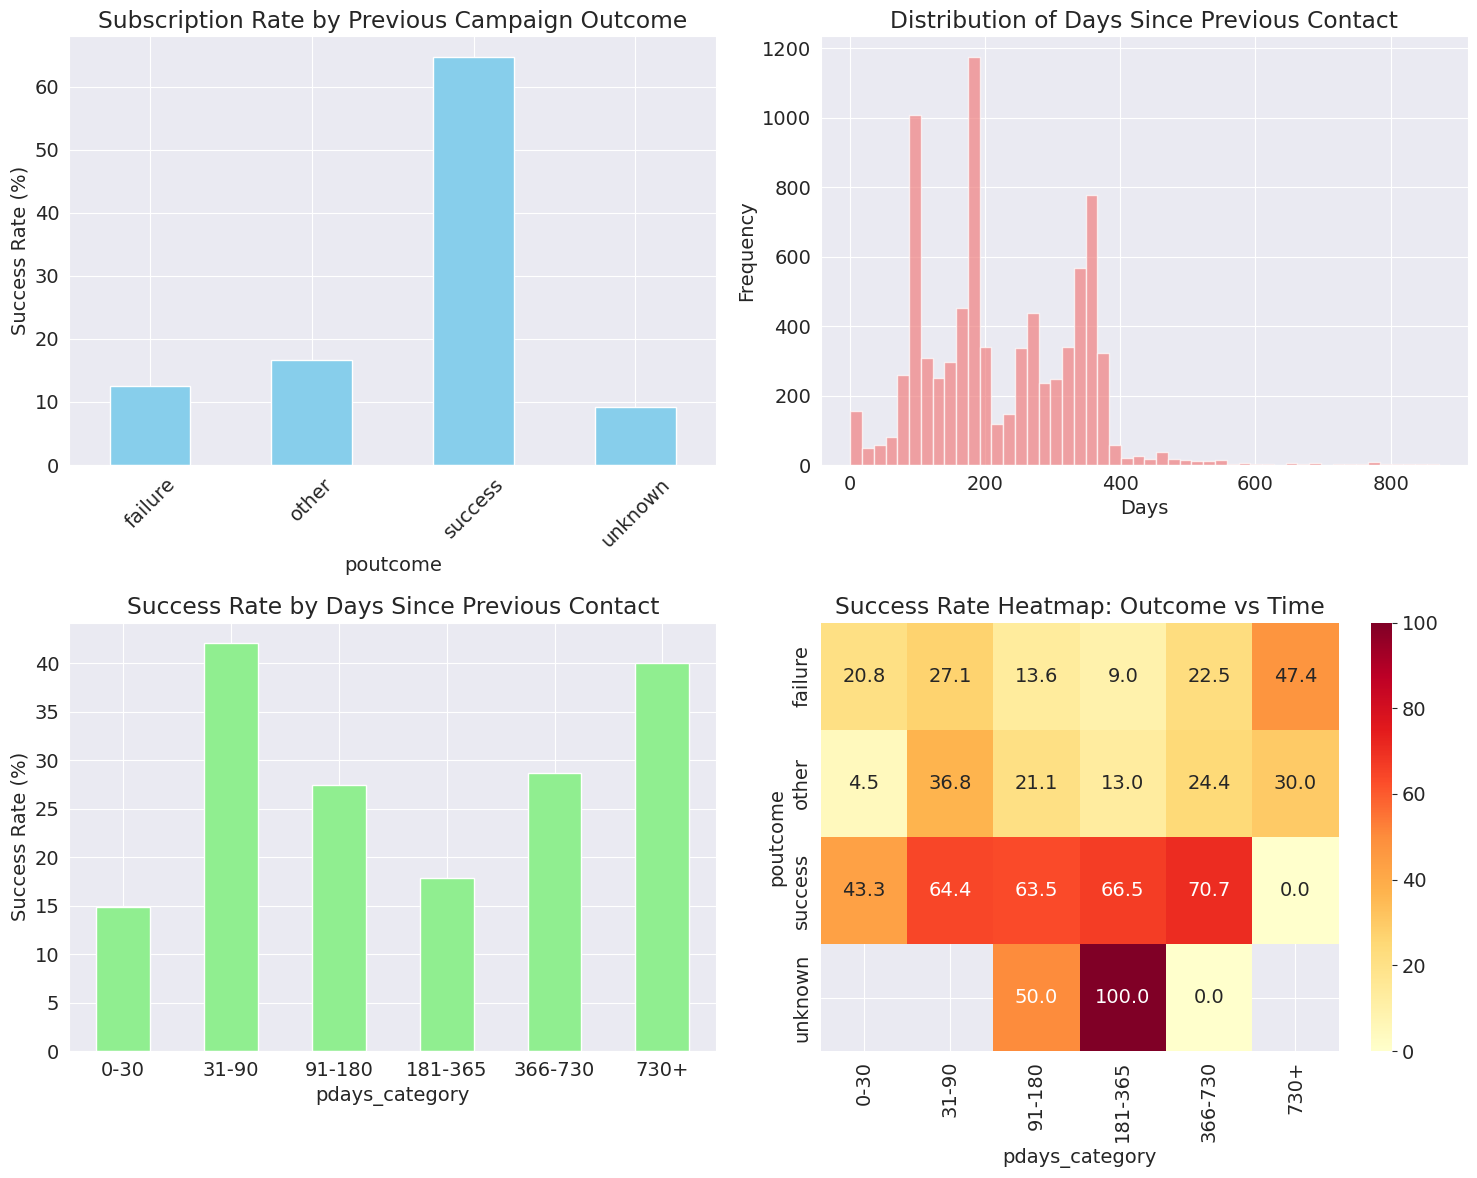

In [48]:
# visualization
create_visualizations(df1)

In [51]:
def build_lead_scoring_model(df):
    """
    Build an intelligent lead scoring model
    """

    # Prepare features for modeling
    df_model = df.copy()

    # Create engineered features
    df_model['never_contacted'] = (df_model['pdays'] == -1).astype(int)
    # Replace -1 with 0 for modeling
    df_model['pdays_clean'] = df_model['pdays'].replace(-1, 0)  # Replace -1 with 0 for modeling

    # Create pdays categories as features
    df_model['pdays_recent'] = ((df_model['pdays'] > 0) & (df_model['pdays'] <= 90)).astype(int)
    df_model['pdays_medium'] = ((df_model['pdays'] > 90) & (df_model['pdays'] <= 180)).astype(int)
    df_model['pdays_long'] = (df_model['pdays'] > 180).astype(int)

    # Encode categorical variables
    le_dict = {}
    categorical_cols = ['age_group', 'job', 'marital', 'education', 'default', 'housing', 'loan',
                      'contact', 'month', 'poutcome']

    for col in categorical_cols:
        le = LabelEncoder()
        df_model[f'{col}_encoded'] = le.fit_transform(df_model[col])
        le_dict[col] = le

    # Select features for the model
    feature_cols = ['balance', 'duration', 'campaign', 'previous', 'never_contacted',
                   'pdays_clean', 'pdays_recent', 'pdays_medium', 'pdays_long'] + \
                   [f'{col}_encoded' for col in categorical_cols]

    X = df_model[feature_cols]
    y = df_model['y_encoded']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf_model.fit(X_train, y_train)


    # Create lead scores for the entire dataset
    lead_scores = rf_model.predict_proba(X)[:, 1]
    df_model['lead_score'] = lead_scores

    return df_model

In [52]:
def create_lead_scoring_strategy(df):
    """
    Create actionable lead scoring strategy
    """
    df_with_scores = build_lead_scoring_model(df)
    # Define score categories
    df_with_scores['score_category'] = pd.cut(
        df_with_scores['lead_score'],
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=['Very Low (0-20%)', 'Low (20-40%)', 'Medium (40-60%)',
                'High (60-80%)', 'Very High (80-100%)']
    )

    # Analyze performance by score category
    score_analysis = df_with_scores.groupby('score_category',  observed=True).agg({
        'y': [lambda x: (x == 'Subscription').sum(), 'count', lambda x: (x == 'Subscription').mean() * 100],
        'lead_score': 'mean'
    }).round(3)

    score_analysis.columns = ['Actual_Subscriptions', 'Total_Leads', 'Conversion_Rate_%', 'Avg_Score']

    print("LEAD SCORE PERFORMANCE:")
    print("-" * 25)
    print(score_analysis)

    # Specific insights for poutcome and pdays
    print("\n\nSPECIFIC INSIGHTS:")
    print("-" * 20)

    # High scoring leads analysis
    high_score_leads = df_with_scores[df_with_scores['lead_score'] >= 0.6]
    print(f"High-score leads (60%+): {len(high_score_leads):,} leads")
    print(f"Their conversion rate: {(high_score_leads['y'] == 'Subscription').mean() * 100:.1f}%")
    print(f"Previous outcome distribution:")
    print(high_score_leads['poutcome'].value_counts())

    # Recommendations by poutcome and pdays combination
    print(f"\n\nACTIONABLE RECOMMENDATIONS:")
    print("-" * 30)

    recommendations = []

    # Analyze success cases
    success_leads = df_with_scores[df_with_scores['poutcome'] == 'success']
    if len(success_leads) > 0:
        avg_score_success = success_leads['lead_score'].mean()
        recommendations.append(f"• Previous SUCCESS clients have average score of {avg_score_success:.1%}")

        # Best timing for success clients
        success_contacted = success_leads[success_leads['pdays'] != -1]
        if len(success_contacted) > 0:
            best_timing = success_contacted.groupby(
                pd.cut(success_contacted['pdays'], bins=[0, 30, 90, 180, 365, 730, float('inf')]), observed=True
            )['lead_score'].mean()
            best_period = best_timing.idxmax()
            recommendations.append(f"• Best recontact timing for previous success: {best_period}")

    # Analyze failure cases
    failure_leads = df_with_scores[df_with_scores['poutcome'] == 'failure']
    if len(failure_leads) > 0:
        high_score_failures = failure_leads[failure_leads['lead_score'] >= 0.3]
        if len(high_score_failures) > 0:
            recommendations.append(f"• {len(high_score_failures)} previous FAILURE clients still have medium+ scores")
            avg_pdays_recovery = high_score_failures['pdays'].mean()
            recommendations.append(f"• Average recovery time for failed clients: {avg_pdays_recovery:.0f} days")

    # Never contacted analysis
    never_contacted = df_with_scores[df_with_scores['pdays'] == -1]
    avg_score_new = never_contacted['lead_score'].mean()
    high_score_new = (never_contacted['lead_score'] >= 0.4).sum()
    recommendations.append(f"• Never contacted clients average score: {avg_score_new:.1%}")
    recommendations.append(f"• {high_score_new:,} never-contacted leads have medium+ potential")

    for rec in recommendations:
        print(rec)

    return score_analysis

In [53]:
create_lead_scoring_strategy(df1)

LEAD SCORE PERFORMANCE:
-------------------------
                     Actual_Subscriptions  Total_Leads  Conversion_Rate_%  \
score_category                                                              
Very Low (0-20%)                     1083        36934              2.932   
Low (20-40%)                         1181         4115             28.700   
Medium (40-60%)                      1844         2872             64.206   
High (60-80%)                         985         1092             90.201   
Very High (80-100%)                   196          198             98.990   

                     Avg_Score  
score_category                  
Very Low (0-20%)         0.047  
Low (20-40%)             0.294  
Medium (40-60%)          0.491  
High (60-80%)            0.693  
Very High (80-100%)      0.825  


SPECIFIC INSIGHTS:
--------------------
High-score leads (60%+): 1,290 leads
Their conversion rate: 91.6%
Previous outcome distribution:
poutcome
success    922
unknown    213
f

,Actual_Subscriptions,Total_Leads,Conversion_Rate_%,Avg_Score
score_category,,,,
Very Low (0-20%),1083,36934,2.932,0.047
Low (20-40%),1181,4115,28.700,0.294
Medium (40-60%),1844,2872,64.206,0.491
High (60-80%),985,1092,90.201,0.693
Very High (80-100%),196,198,98.990,0.825


Finding Insight from the above:

1. Previous success clients have success subcription rate of  64%

2. Best recontact timing for previous success: **(365.0, 730.0 days)** and it decrease from **(365.0, 730.0)** to **31-90 days**

3. Best recontact days for highest success subcription rate is within **31-90 days**

4. **Are there specific combinations of housing and personal loan statuses (housing, loan) and credit default (default) that significantly impact term deposit subscription rates, and how should these financial attributes be considered when approaching clients?**

#### Individual Analysis

In [54]:
def individual_attribute_analysis(df):
    """
    Analyze each financial attribute individually
    """
    attributes = ['housing', 'loan', 'default']
    individual_results = {}

    for attr in attributes:
        print(f"\n{attr.upper()} LOAN IMPACT:")
        print("-" * 25)

        # Calculate subscription rates
        attr_analysis = df.groupby(attr, observed=True).agg({
            'y_encoded': ['sum', 'count', 'mean'],
            'balance': 'mean'
        }).round(3)

        attr_analysis.columns = ['Subscriptions', 'Total_Clients', 'Success_Rate', 'Avg_Balance']
        attr_analysis['Success_Rate_Pct'] = attr_analysis['Success_Rate'] * 100

        print(attr_analysis[['Subscriptions', 'Total_Clients', 'Success_Rate_Pct', 'Avg_Balance']])

        # Statistical significance test
        contingency_table = pd.crosstab(df[attr], df['y'])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-square test p-value: {p_value:.6f}")
        print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'}")

        # Calculate effect size (Cramér's V)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        print(f"Effect size (Cramér's V): {cramers_v:.3f}")



In [55]:
individual_attribute_analysis(df1)


HOUSING LOAN IMPACT:
-------------------------
             Subscriptions  Total_Clients  Success_Rate_Pct  Avg_Balance
housing                                                                 
Mortgage              1935          25130               7.7     1175.103
No_Mortgage           3354          20081              16.7     1596.501
Chi-square test p-value: 0.000000
Statistical significance: Yes
Effect size (Cramér's V): 0.139

LOAN LOAN IMPACT:
-------------------------
      Subscriptions  Total_Clients  Success_Rate_Pct  Avg_Balance
loan                                                             
no             4805          37967              12.7     1474.454
yes             484           7244               6.7      774.310
Chi-square test p-value: 0.000000
Statistical significance: Yes
Effect size (Cramér's V): 0.068

DEFAULT LOAN IMPACT:
-------------------------
         Subscriptions  Total_Clients  Success_Rate_Pct  Avg_Balance
default                                   

#### Combination Analysis

In [56]:
def combination_analysis(df):
    """
    Analyze combinations of financial attributes
    """
    print("\n\n3. COMBINATION ANALYSIS")
    print("-" * 30)

    # Create combined categories
    df['financial_profile'] = df['housing'] + '_' + df['loan'] + '_' + df['default']

    # All possible combinations
    combo_analysis = df.groupby('financial_profile', observed=True).agg({
        'y_encoded': ['sum', 'count', 'mean'],
        'balance': 'mean',
        'age': 'mean'
    }).round(2)

    combo_analysis.columns = ['Subscriptions', 'Total_Clients', 'Success_Rate', 'Avg_Balance', 'Avg_Age']
    combo_analysis['Success_Rate_Pct'] = combo_analysis['Success_Rate'] * 100
    combo_analysis = combo_analysis.sort_values('Success_Rate_Pct', ascending=False)

    print("ALL FINANCIAL COMBINATIONS (sorted by success rate):")
    print("-" * 55)
    print(combo_analysis[['Total_Clients', 'Success_Rate_Pct', 'Avg_Balance', 'Avg_Age']])

    # Focus on meaningful combinations (with sufficient sample size)
    significant_combos = combo_analysis[combo_analysis['Total_Clients'] >= 100].copy()

    print(f"\n\nSIGNIFICANT COMBINATIONS (n≥100):")
    print("-" * 40)
    print(significant_combos[['Total_Clients', 'Success_Rate_Pct', 'Avg_Balance']])

    return combo_analysis, significant_combos


In [57]:
combo_analysis, significant_combos=combination_analysis(df1)



3. COMBINATION ANALYSIS
------------------------------
ALL FINANCIAL COMBINATIONS (sorted by success rate):
-------------------------------------------------------
                     Total_Clients  Success_Rate_Pct  Avg_Balance  Avg_Age
financial_profile                                                         
No_Mortgage_no_no            16992              18.0      1759.50    43.28
Mortgage_no_no               20461               8.0      1277.83    39.16
No_Mortgage_yes_no            2709               8.0       808.20    42.48
Mortgage_no_yes                302               7.0      -194.78    37.83
No_Mortgage_no_yes             212               7.0       -17.51    41.48
Mortgage_yes_no               4234               6.0       819.39    39.37
Mortgage_yes_yes               133               5.0      -193.65    37.94
No_Mortgage_yes_yes            168               5.0      -142.09    41.40


SIGNIFICANT COMBINATIONS (n≥100):
----------------------------------------
       

In [ ]:
combo_analysis

,Subscriptions,Total_Clients,Success_Rate,Avg_Balance,Avg_Age,Success_Rate_Pct
financial_profile,,,,,,
No_Mortgage_no_no,3120,16992,0.18,1759.50,43.28,18.0
Mortgage_no_no,1648,20461,0.08,1277.83,39.16,8.0
No_Mortgage_yes_no,211,2709,0.08,808.20,42.48,8.0
Mortgage_no_yes,22,302,0.07,-194.78,37.83,7.0
No_Mortgage_no_yes,15,212,0.07,-17.51,41.48,7.0
Mortgage_yes_no,258,4234,0.06,819.39,39.37,6.0
Mortgage_yes_yes,7,133,0.05,-193.65,37.94,5.0
No_Mortgage_yes_yes,8,168,0.05,-142.09,41.40,5.0


In [ ]:
 significant_combos

,Subscriptions,Total_Clients,Success_Rate,Avg_Balance,Avg_Age,Success_Rate_Pct
financial_profile,,,,,,
No_Mortgage_no_no,3120,16992,0.18,1759.50,43.28,18.0
Mortgage_no_no,1648,20461,0.08,1277.83,39.16,8.0
No_Mortgage_yes_no,211,2709,0.08,808.20,42.48,8.0
Mortgage_no_yes,22,302,0.07,-194.78,37.83,7.0
No_Mortgage_no_yes,15,212,0.07,-17.51,41.48,7.0
Mortgage_yes_no,258,4234,0.06,819.39,39.37,6.0
Mortgage_yes_yes,7,133,0.05,-193.65,37.94,5.0
No_Mortgage_yes_yes,8,168,0.05,-142.09,41.40,5.0


In [58]:
def create_financial_visualizations(df):
    """
    Create comprehensive visualizations
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Individual attribute success rates
    attributes = ['housing', 'loan', 'default']
    for i, attr in enumerate(attributes):
        rates = df.groupby(attr, observed=True)['y_encoded'].mean() * 100
        rates.plot(kind='bar', ax=axes[0, i], color=['lightcoral', 'lightblue'])
        axes[0, i].set_title(f'Success Rate by {attr.title()}')
        axes[0, i].set_ylabel('Success Rate (%)')
        axes[0, i].tick_params(axis='x', rotation=0)

    # 2. Combination heatmap
    # Create a pivot table for housing vs loan (ignoring default for simplicity)
    pivot_data = df.groupby(['housing', 'loan'], observed=True)['y_encoded'].mean() * 100
    pivot_df = pivot_data.unstack()

    sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[1, 0])
    axes[1, 0].set_title('Success Rate: Housing vs Personal Loan')

    # 3. Balance distribution by financial profile
    df['has_any_loan'] = ((df['housing'] == 'Mortgage') | (df['loan'] == 'yes')).astype(str)
    df['has_any_loan'] = df['has_any_loan'].map({'True': 'Has Loan', 'False': 'No Loans'})

    df.boxplot(column='balance', by='has_any_loan', ax=axes[1, 1])
    axes[1, 1].set_title('Balance Distribution by Loan Status')
    axes[1, 1].set_xlabel('Loan Status')

    # 4. Success rate by number of financial products
    df['total_financial_products'] = (df['housing'] == 'Mortgage').astype(int) + (df['loan'] == 'yes').astype(int) + (df['default'] == 'yes').astype(int)

    product_rates = df.groupby('total_financial_products', observed=True)['y_encoded'].mean() * 100
    product_rates.plot(kind='bar', ax=axes[1, 2], color='lightgreen')
    axes[1, 2].set_title('Success Rate by Number of Financial Products')
    axes[1, 2].set_xlabel('Number of Financial Products')
    axes[1, 2].set_ylabel('Success Rate (%)')
    axes[1, 2].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()


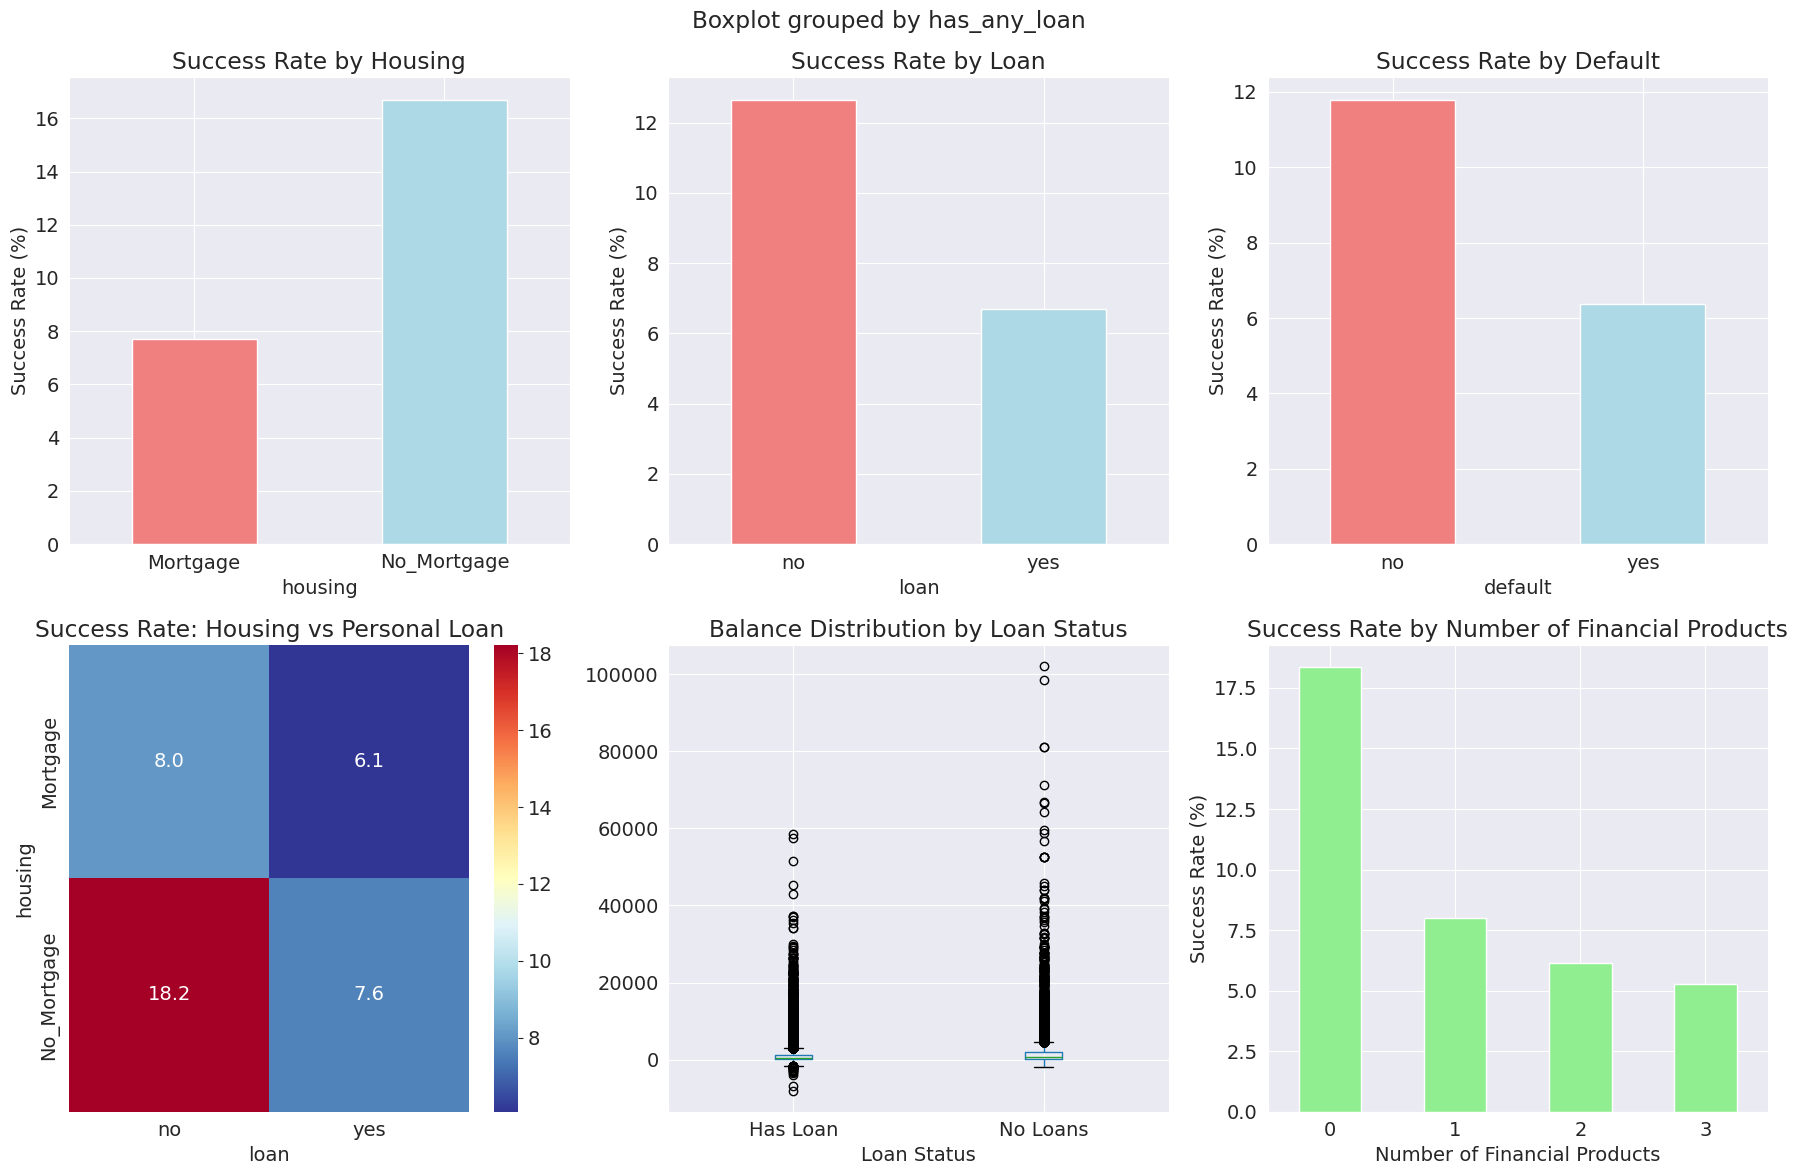

In [59]:
create_financial_visualizations(df1)

Key findings and insight from above:

1. There are statistical significant for the status of default, housing and personal loan. Clients without mortgages are more than **2x as likely** to subscribe (16.7% vs 7.7%). Also clients with financial commitment (without loan default are also **2x as likely** to subscribe

2. Clients with finanacial profile **(No_Mortgage_no_no)** have hightest success rate of **18%**of subcription to deposit term.

3. The number of financial product such as mortage, personal loan and loan default decrease the success rate of subcription.

# 3. Preprocessing and Feature Engineering<a id='fe'></a>



In [ ]:
df1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'age_group', 'y_encoded', 'pdays_group',
       'financial_profile'],
      dtype='object')

In [60]:
def feature_engineering(df):
    """
    Build a model to predict subscription based on financial attributes
    """

    # Prepare features
    df_model = df.copy()

    # Create engineered features
    df_model['never_contacted'] = (df_model['pdays'] == -1).astype(int)
    # Create pdays categories as features
    df_model['pdays_recent'] = ((df_model['pdays'] > 0) & (df_model['pdays'] <= 180)).astype(int)
    df_model['pdays_medium'] = ((df_model['pdays'] > 180) & (df_model['pdays'] <= 360)).astype(int)
    df_model['pdays_long'] = (df_model['pdays'] > 360).astype(int)
    bins = [18, 27, 43, 59, 100]
    labels = ['Gen Z (18-27)', 'Millennials (28-43)',
              'Gen X (44-59)', 'Baby Boomers (60+)']
    df_model['age_group'] = pd.cut(df_model['age'], bins=bins, labels=labels, right=True, include_lowest=True)
    # Decode loan_default
    df_model['y_encoded'] = df_model['y'].apply(lambda x: 1 if x == "yes" else 0)
    df_model['has_housing_loan'] = (df_model['housing'] == 'yes').astype(int)
    df_model['has_personal_loan'] = (df_model['loan'] == 'yes').astype(int)
    df_model['has_default'] = (df_model['default'] == 'yes').astype(int)
    df_model['total_loans'] = df_model['has_housing_loan'] + df_model['has_personal_loan']
    df_model['any_financial_risk'] = ((df_model['has_housing_loan'] == 1) |
                                     (df_model['has_personal_loan'] == 1) |
                                     (df_model['has_default'] == 1)).astype(int)




    # Include other relevant features
    feature_cols = ['has_housing_loan', 'has_personal_loan', 'has_default',
                   'total_loans', 'any_financial_risk', 'pdays_recent','pdays_medium', 'pdays_long', 'never_contacted']
    numeric_cols = ['balance', 'duration', 'campaign', 'previous']
    # Encode other categorical variables if needed
    categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome','age_group']
    le_dict = {}
    Scaler_dict = {}
    for col in categorical_cols:
        if col in df_model.columns:
            le = LabelEncoder()
            df_model[f'{col}_encoded'] = le.fit_transform(df_model[col])
            feature_cols.append(f'{col}_encoded')
            le_dict[col] = le

    for col in numeric_cols:
        if col in df_model.columns:
            scaler = MinMaxScaler()
            df_model[col] = scaler.fit_transform(df_model[[col]])
            feature_cols.append(col)
            Scaler_dict[col]=scaler
    X = df_model[feature_cols]
    y = df_model['y_encoded']
    return X,y,le_dict,Scaler_dict

In [61]:
def save_encoders_scalers(le_dict, scaler_dict):
    """Save encoders and scalers"""
    try:
        with open('label_encoders.pkl', 'wb') as f:
            pickle.dump(le_dict, f)
        print("✓ Label encoders saved successfully")
    except Exception as e:
        print(f"✗ Error saving label encoders: {e}")

    try:
        with open('scalers.pkl', 'wb') as f:
            pickle.dump(scaler_dict, f)
        print("✓ Scalers saved successfully")
    except Exception as e:
        print(f"✗ Error saving scalers: {e}")

In [62]:
df10 =load_and_format_data("/content/drive/MyDrive/Azubi Africa/bank.csv")

✓ Successfully converted to string


<ipython-input-4-c8c7f420543f>:68: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  new_df[col] = pd.to_numeric(new_df[col], errors="ignore")


In [63]:
df3 = pd.concat([df, df10]).drop_duplicates(keep=False)

In [66]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [67]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40690 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40690 non-null  int64 
 1   job        40690 non-null  object
 2   marital    40690 non-null  object
 3   education  40690 non-null  object
 4   default    40690 non-null  object
 5   balance    40690 non-null  int64 
 6   housing    40690 non-null  object
 7   loan       40690 non-null  object
 8   contact    40690 non-null  object
 9   day        40690 non-null  int64 
 10  month      40690 non-null  object
 11  duration   40690 non-null  int64 
 12  campaign   40690 non-null  int64 
 13  pdays      40690 non-null  int64 
 14  previous   40690 non-null  int64 
 15  poutcome   40690 non-null  object
 16  y          40690 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.6+ MB


In [68]:
X,y,le_dict,Scaler_dict=feature_engineering(df3)

In [70]:
save_encoders_scalers(le_dict, Scaler_dict)

✓ Label encoders saved successfully
✓ Scalers saved successfully


In [71]:
X

,has_housing_loan,has_personal_loan,has_default,total_loans,any_financial_risk,pdays_recent,pdays_medium,pdays_long,never_contacted,job_encoded,marital_encoded,education_encoded,contact_encoded,month_encoded,poutcome_encoded,age_group_encoded,balance,duration,campaign,previous
0,1,0,0,1,1,0,0,0,1,4,1,2,2,8,3,1,0.092259,0.053070,0.000000,0.000000
1,1,0,0,1,1,0,0,0,1,9,2,1,2,8,3,1,0.073067,0.030704,0.000000,0.000000
2,1,1,0,2,1,0,0,0,1,2,1,1,2,8,3,3,0.072822,0.015453,0.000000,0.000000
3,1,0,0,1,1,0,0,0,1,1,1,3,2,8,3,1,0.086476,0.018707,0.000000,0.000000
4,0,0,0,0,0,0,0,0,1,11,2,3,2,8,3,3,0.072812,0.040260,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0,0,0,0,0,0,0,0,1,9,1,2,0,9,3,1,0.080293,0.198658,0.032258,0.000000
45207,0,0,0,0,0,0,0,0,1,5,0,0,0,9,3,0,0.088501,0.092721,0.016129,0.000000
45208,0,0,0,0,0,0,1,0,0,5,1,1,0,9,2,0,0.124689,0.229158,0.064516,0.010909
45209,0,0,0,0,0,0,0,0,1,1,1,1,1,9,3,1,0.078868,0.103294,0.048387,0.000000


### Train test Split<a id='tts'></a>

In [72]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# #Apply Smote on the three set
# smote = SMOTE(sampling_strategy=0.5, random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [73]:
 y_train.value_counts(normalize=True)

,proportion
y_encoded,
0,0.882834
1,0.117166


# 4. Model Building And Evaluation

Report for ExtraTrees- Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28738
           1       1.00      1.00      1.00      3814

    accuracy                           1.00     32552
   macro avg       1.00      1.00      1.00     32552
weighted avg       1.00      1.00      1.00     32552

Report for ExtraTrees- Test Data
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7184
           1       0.61      0.34      0.44       954

    accuracy                           0.90      8138
   macro avg       0.76      0.66      0.69      8138
weighted avg       0.88      0.90      0.88      8138



<Figure size 600x400 with 0 Axes>

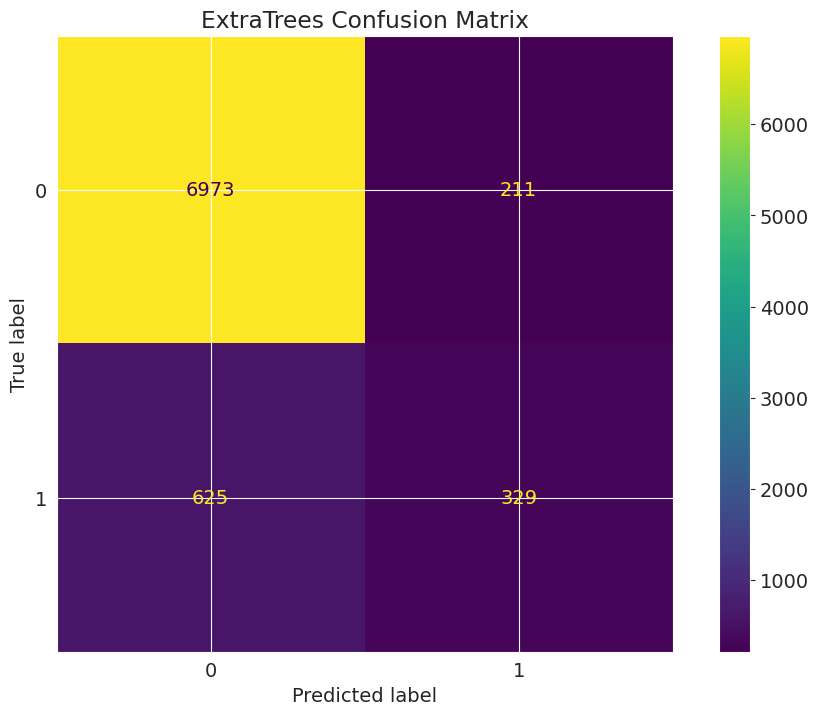

Report for DecisionTree- Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28738
           1       1.00      1.00      1.00      3814

    accuracy                           1.00     32552
   macro avg       1.00      1.00      1.00     32552
weighted avg       1.00      1.00      1.00     32552

Report for DecisionTree- Test Data
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7184
           1       0.44      0.44      0.44       954

    accuracy                           0.87      8138
   macro avg       0.68      0.68      0.68      8138
weighted avg       0.87      0.87      0.87      8138



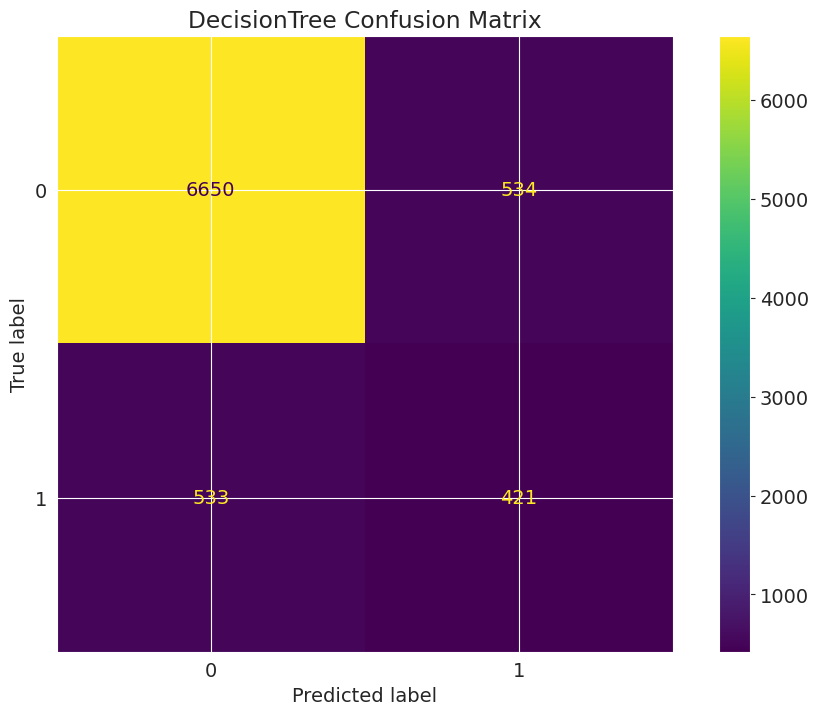

Report for RandomForest- Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28738
           1       1.00      1.00      1.00      3814

    accuracy                           1.00     32552
   macro avg       1.00      1.00      1.00     32552
weighted avg       1.00      1.00      1.00     32552

Report for RandomForest- Test Data
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7184
           1       0.65      0.40      0.50       954

    accuracy                           0.90      8138
   macro avg       0.79      0.69      0.72      8138
weighted avg       0.89      0.90      0.89      8138



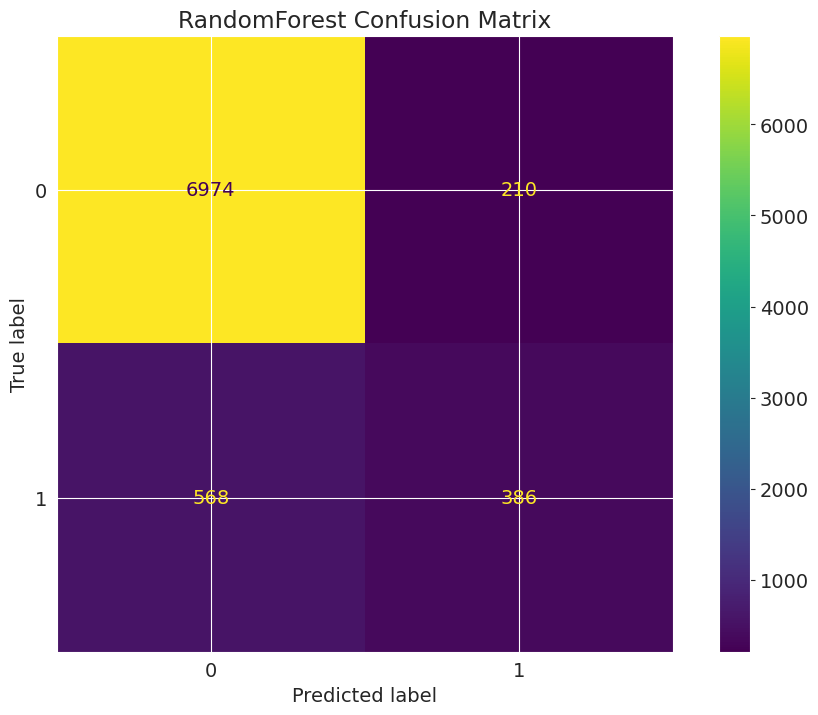

Report for GradientBoosting- Train Data
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     28738
           1       0.69      0.42      0.52      3814

    accuracy                           0.91     32552
   macro avg       0.81      0.70      0.74     32552
weighted avg       0.90      0.91      0.90     32552

Report for GradientBoosting- Test Data
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7184
           1       0.68      0.40      0.51       954

    accuracy                           0.91      8138
   macro avg       0.80      0.69      0.73      8138
weighted avg       0.90      0.91      0.90      8138



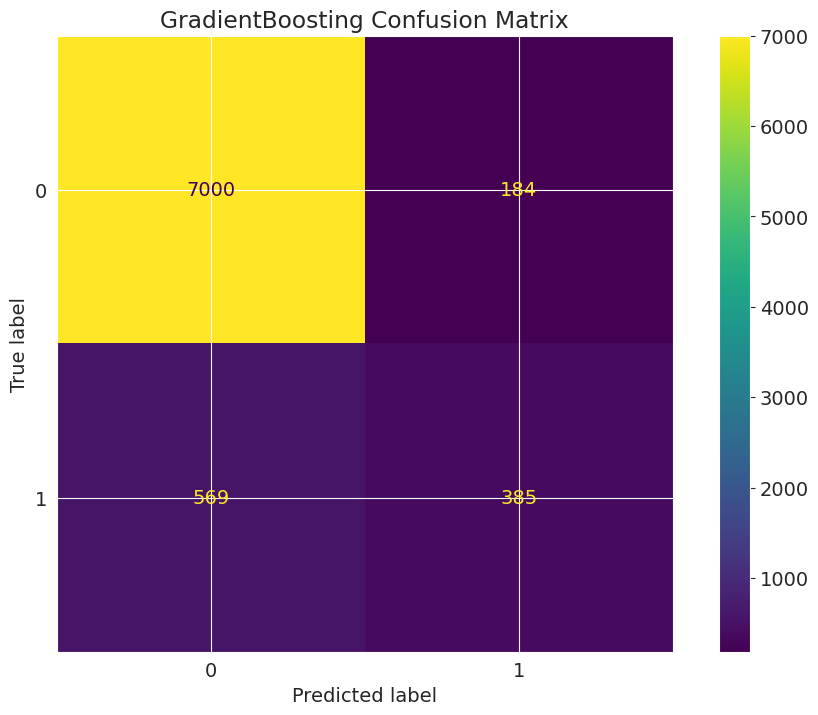

Report for XGB- Train Data
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28738
           1       0.86      0.68      0.76      3814

    accuracy                           0.95     32552
   macro avg       0.91      0.83      0.87     32552
weighted avg       0.95      0.95      0.95     32552

Report for XGB- Test Data
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7184
           1       0.62      0.46      0.53       954

    accuracy                           0.90      8138
   macro avg       0.78      0.71      0.74      8138
weighted avg       0.89      0.90      0.90      8138



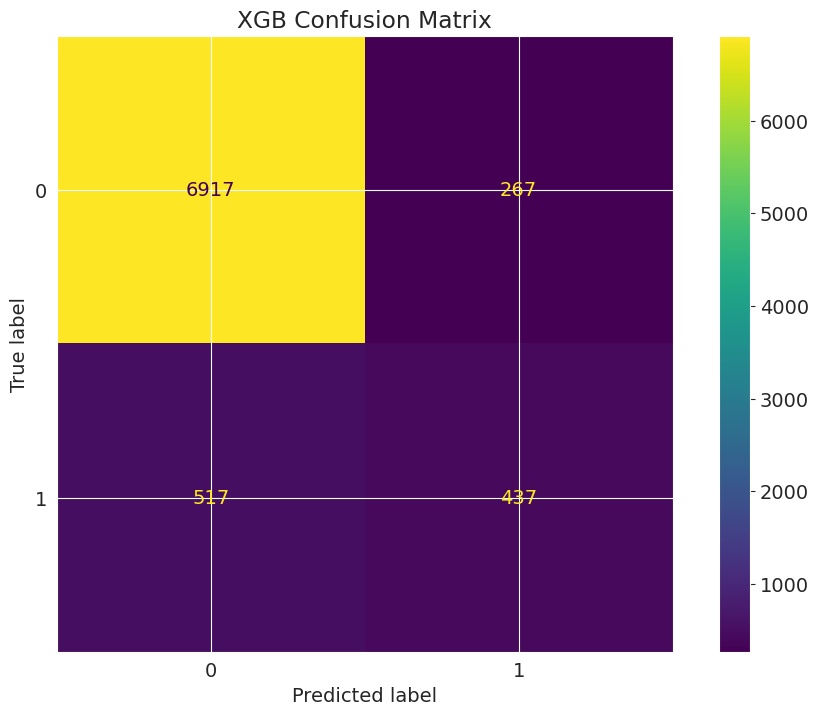

[LightGBM] [Info] Number of positive: 3814, number of negative: 28738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 32552, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117166 -> initscore=-2.019542
[LightGBM] [Info] Start training from score -2.019542
Report for LGBM- Train Data
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     28738
           1       0.74      0.56      0.64      3814

    accuracy                           0.93     32552
   macro avg       0.84      0.77      0.80     32552
weighted avg       0.92      0.93      0.92     32552

Report for LGBM- Test Data
              precision    recall  f1-score   support

       

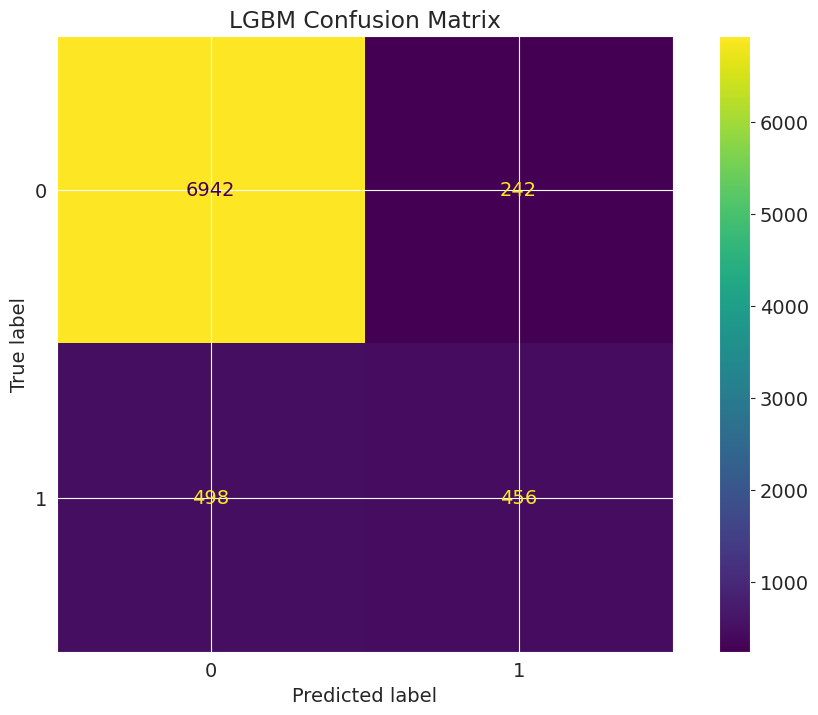

Report for AdaBoost- Train Data
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     28738
           1       0.62      0.32      0.42      3814

    accuracy                           0.90     32552
   macro avg       0.76      0.64      0.68     32552
weighted avg       0.88      0.90      0.88     32552

Report for AdaBoost- Test Data
              precision    recall  f1-score   support

           0       0.92      0.98      0.94      7184
           1       0.63      0.32      0.43       954

    accuracy                           0.90      8138
   macro avg       0.77      0.65      0.69      8138
weighted avg       0.88      0.90      0.88      8138



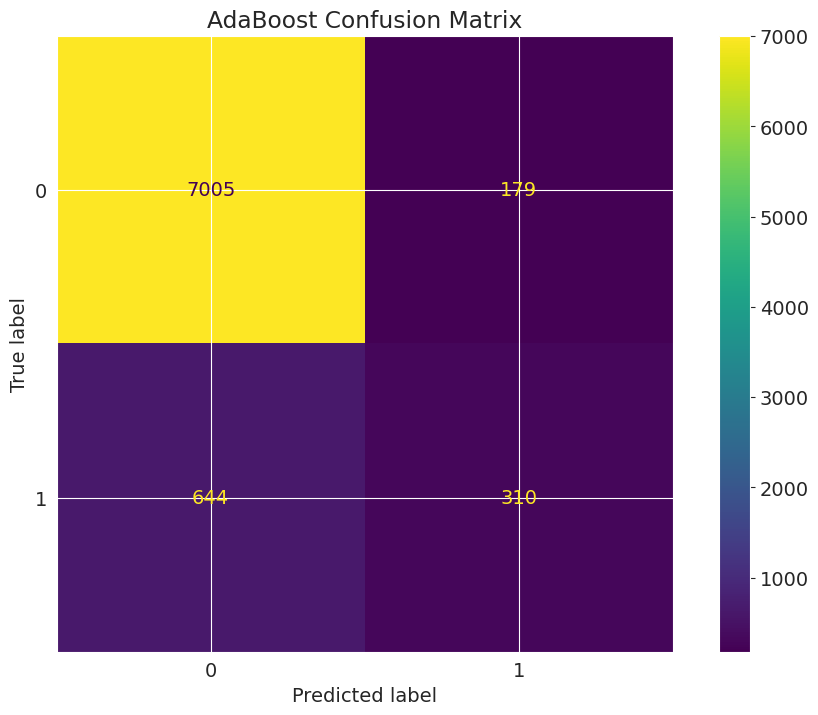

Report for Svm- Train Data
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     28738
           1       0.77      0.03      0.06      3814

    accuracy                           0.89     32552
   macro avg       0.83      0.52      0.50     32552
weighted avg       0.87      0.89      0.84     32552

Report for Svm- Test Data
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7184
           1       0.75      0.03      0.06       954

    accuracy                           0.89      8138
   macro avg       0.82      0.52      0.50      8138
weighted avg       0.87      0.89      0.84      8138



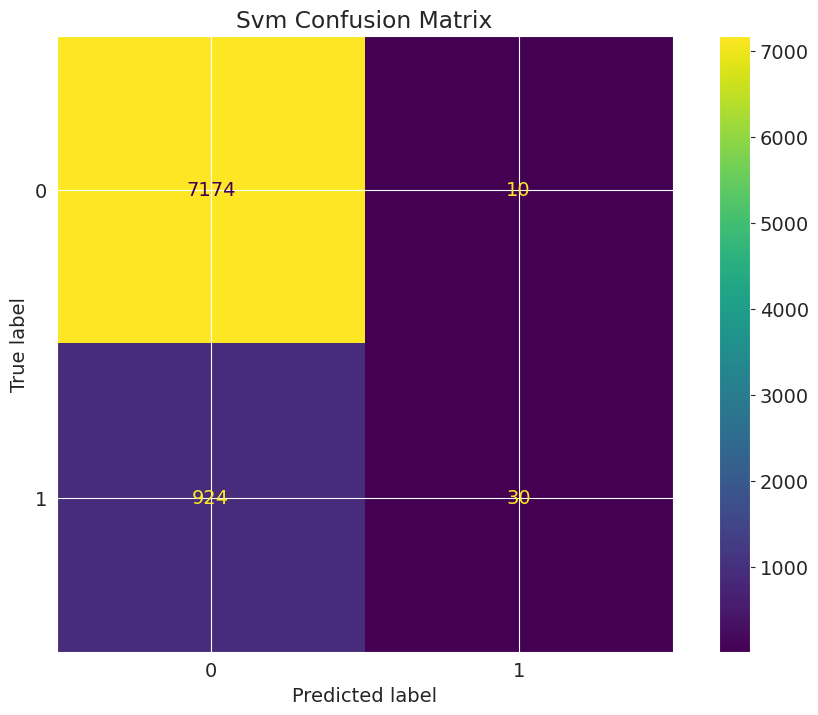

In [79]:
plt.figure(figsize=(6, 4))
# Define classifiers
Classifiers = [
    ['ExtraTrees', ExtraTreesClassifier()],
    ['DecisionTree', DecisionTreeClassifier()],
    ['RandomForest', RandomForestClassifier()],
    ['GradientBoosting', GradientBoostingClassifier()],
    ['XGB', XGBClassifier()],
    ['LGBM', LGBMClassifier()],
    ['AdaBoost', AdaBoostClassifier()],
    ['Svm', SVC()]
]

# DataFrame to store performance metrics
results_list = []
# DataFrame to store predictions
predictions_df = pd.DataFrame()
predictions_df["True_Label"] = y_test

for name, clf in Classifiers:
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)

    # Compute evaluation metrics
    train_f1 = f1_score(y_train, train_predictions)
    test_f1 = f1_score(y_test, test_predictions)
    train_recall = recall_score(y_train, train_predictions)
    test_recall = recall_score(y_test, test_predictions)

    # Store predictions
    predictions_df[name] = test_predictions

    print(f"Report for {name}- Train Data")
    print(classification_report(y_train, train_predictions))

    print(f"Report for {name}- Test Data")
    print(classification_report(y_test, test_predictions))
    # Store model performance
    results_list.append({
        "Model": name,
        "Train F1": round(train_f1, 2),
        "Test F1": round(test_f1, 2),
        "Train Recall": round(train_recall, 2),
        "Test Recall": round(test_recall, 2)
    })

    # Generate array of values for confusion matrix

    cm = confusion_matrix(y_test, test_predictions)

# Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
    disp.plot(values_format='');
    plt.title(f"{name} Confusion Matrix")
    plt.show()


From the above result **XGB** and **LGBMClassifier** outperforms other models with higher F1 and Precison Will finetune the parameter

### Fine Tuning Model

### Tune XGBClassifier for Explainable<a id='ex'></a>

##### GridSearch

In [80]:
# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

In [82]:
xgb_grid = GridSearchCV(
        estimator=xgb_model,
        param_grid=xgb_param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

xgb_grid.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation score: {xgb_grid.best_score_:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.5355


In [ ]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', learning_rate= 0.1, max_depth=6,
                          n_estimators=200, colsample_bytree=0.8, subsample=0.8)
xgb_model.fit(X_train, y_train)

In [83]:
# Test performance
y_pred = xgb_grid.predict(X_test)
y_pred_train = xgb_grid.predict(X_train)

In [84]:
# classification_report for training
print("Classification Report for Training:\n", classification_report(y_train, y_pred_train))

Classification Report for Training:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     28738
           1       0.83      0.62      0.71      3814

    accuracy                           0.94     32552
   macro avg       0.89      0.80      0.84     32552
weighted avg       0.94      0.94      0.94     32552



In [85]:
print("Classification Report Testing:\n", classification_report(y_test, y_pred))

Classification Report Testing:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7184
           1       0.65      0.46      0.54       954

    accuracy                           0.91      8138
   macro avg       0.79      0.71      0.74      8138
weighted avg       0.90      0.91      0.90      8138



##### Random Search

In [88]:
from sklearn.model_selection import RandomizedSearchCV

In [89]:
# Define parameter distribution
xgb_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': np.logspace(-3, 0, 50),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=100,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_random.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {xgb_random.best_params_}")
print(f"Best cross-validation score: {xgb_random.best_score_:.4f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': np.float64(0.9), 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': np.float64(0.10481131341546852), 'colsample_bytree': np.float64(1.0)}
Best cross-validation score: 0.5381


In [90]:
# Test performance
y_pred = xgb_random.predict(X_test)
y_pred_train = xgb_random.predict(X_train)

In [91]:
# classification_report for training
print("Classification Report for Training:\n", classification_report(y_train, y_pred_train))

Classification Report for Training:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     28738
           1       0.87      0.68      0.76      3814

    accuracy                           0.95     32552
   macro avg       0.91      0.83      0.87     32552
weighted avg       0.95      0.95      0.95     32552



In [92]:
print("Classification Report Testing:\n", classification_report(y_test, y_pred))

Classification Report Testing:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      7184
           1       0.63      0.46      0.53       954

    accuracy                           0.91      8138
   macro avg       0.78      0.71      0.74      8138
weighted avg       0.90      0.91      0.90      8138



### LGBMClassifier Fine-tuning

#### Grid Search

In [93]:
# Define parameter grid
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0]
}

lgbm_model = LGBMClassifier(random_state=42, verbose=-1)

# GridSearchCV
lgbm_grid = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

lgbm_grid.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {lgbm_grid.best_params_}")
print(f"Best cross-validation score: {lgbm_grid.best_score_:.4f}")

# Test performance
y_pred = lgbm_grid.predict(X_test)
y_pred_train = lgbm_grid.predict(X_train)



Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'num_leaves': 100}
Best cross-validation score: 0.5300


In [103]:
# classification_report for training
print("Classification Report for Training:\n", classification_report(y_train, y_pred_train))

Classification Report for Training:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     28738
           1       0.81      0.61      0.70      3814

    accuracy                           0.94     32552
   macro avg       0.88      0.80      0.83     32552
weighted avg       0.93      0.94      0.93     32552



In [104]:
print("Classification Report Testing:\n", classification_report(y_test, y_pred))

Classification Report Testing:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      7184
           1       0.64      0.46      0.54       954

    accuracy                           0.91      8138
   macro avg       0.78      0.71      0.74      8138
weighted avg       0.90      0.91      0.90      8138



#### Random Search

In [105]:
# Define parameter distribution
lgbm_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': np.logspace(-3, 0, 50),
    'num_leaves': np.arange(10, 200, 10),
    'feature_fraction': np.linspace(0.6, 1.0, 5),
    'bagging_fraction': np.linspace(0.6, 1.0, 5),
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

lgbm_model = LGBMClassifier(random_state=42, verbose=-1)

# RandomizedSearchCV
lgbm_random = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=lgbm_param_dist,
    n_iter=100,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

lgbm_random.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {lgbm_random.best_params_}")
print(f"Best cross-validation score: {lgbm_random.best_score_:.4f}")

# Test performance
y_pred = lgbm_random.predict(X_test)
y_pred_train = lgbm_random.predict(X_train)




Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': np.int64(20), 'n_estimators': 200, 'max_depth': 5, 'learning_rate': np.float64(0.21209508879201905), 'feature_fraction': np.float64(0.7), 'bagging_fraction': np.float64(0.8)}
Best cross-validation score: 0.5318


In [110]:
# classification_report for training
print("Classification Report for Training:\n", classification_report(y_train, y_pred_train))

Classification Report for Training:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     28738
           1       0.79      0.60      0.68      3814

    accuracy                           0.93     32552
   macro avg       0.87      0.79      0.82     32552
weighted avg       0.93      0.93      0.93     32552



In [111]:
print("Classification Report Testing:\n", classification_report(y_test, y_pred))

Classification Report Testing:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7184
           1       0.64      0.46      0.53       954

    accuracy                           0.91      8138
   macro avg       0.79      0.71      0.74      8138
weighted avg       0.90      0.91      0.90      8138



In [113]:
# final model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', learning_rate= 0.1, max_depth=6,
                          n_estimators=200, colsample_bytree=0.8, subsample=0.8)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [114]:
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

In [116]:
print("Classification Report Testing:\n", classification_report(y_test, y_pred))

Classification Report Testing:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7184
           1       0.65      0.46      0.54       954

    accuracy                           0.91      8138
   macro avg       0.79      0.71      0.74      8138
weighted avg       0.90      0.91      0.90      8138



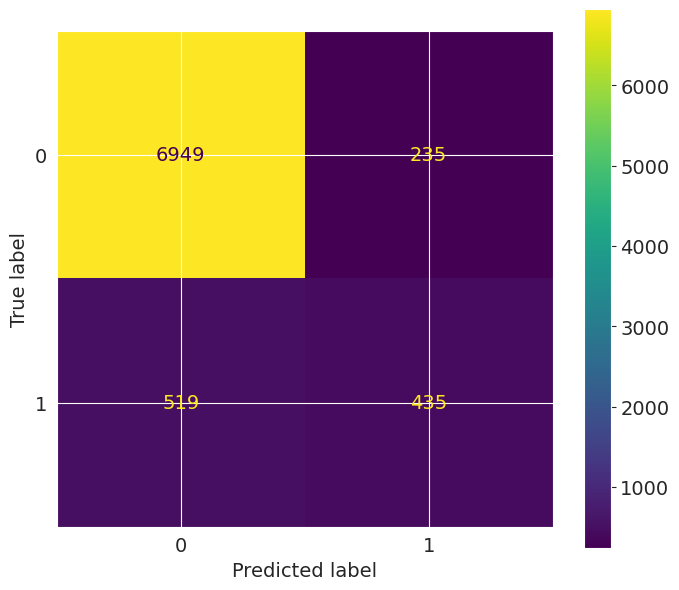

In [115]:
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix without gridlines
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
ax = disp.plot(values_format='', ax=plt.gca())  # Specify the axes

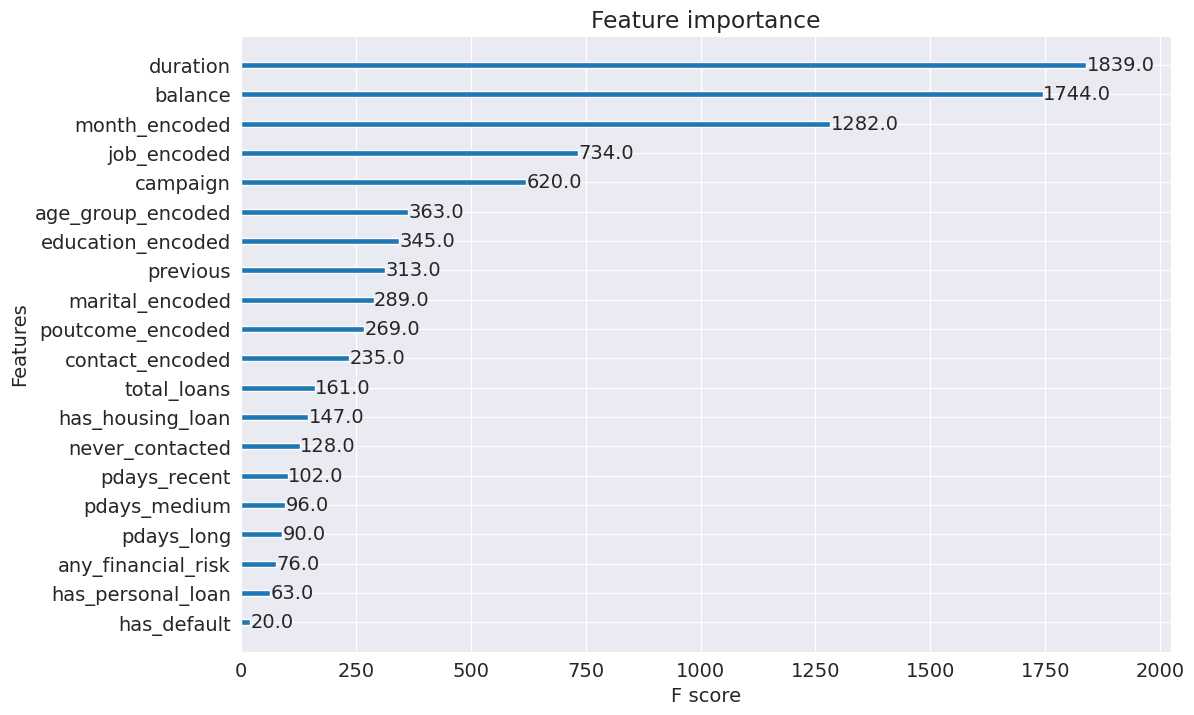

In [117]:
# Feature Importance for xgb_model
import xgboost as xgb
xgb.plot_importance(xgb_model)
plt.show()

In [125]:
import shap


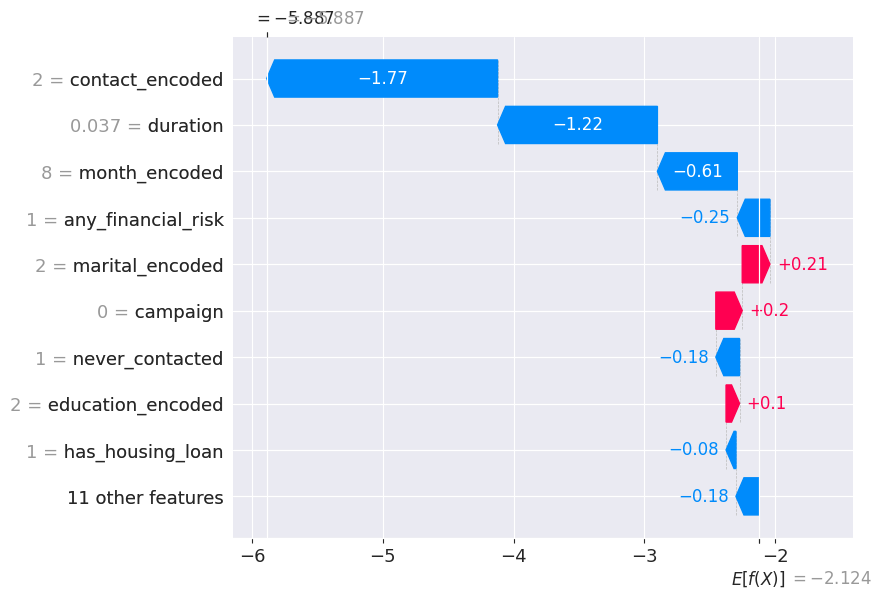

In [124]:
explainer = shap.TreeExplainer(model=xgb_model, data=None, model_output='raw',
                              feature_perturbation='tree_path_dependent')

# Use explainer() method
shap_values = explainer(X_test)

# For binary classification
if len(shap_values.shape) > 2:
    shap.plots.waterfall(shap_values[0, :, 1], max_display=10)  # Class 1
else:
    shap.plots.waterfall(shap_values[0], max_display=10)

In [132]:
# plot for first samples
shap.initjs()
shap.plots.force(shap_values[0])




In [133]:
# plot for first 50 samples
shap.initjs()
shap.plots.force(shap_values[:50])

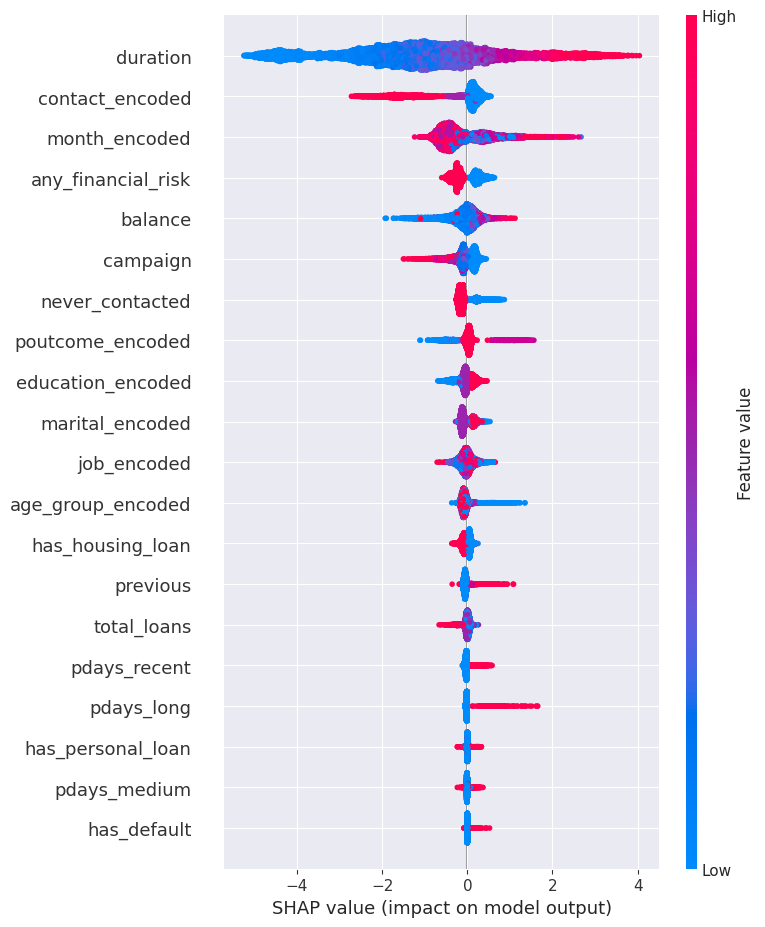

In [131]:
target_names = ["No Subcription", "Subcription"]
# Summary plot
shap.summary_plot(shap_values,X_test, feature_names=X.columns, class_names=target_names)


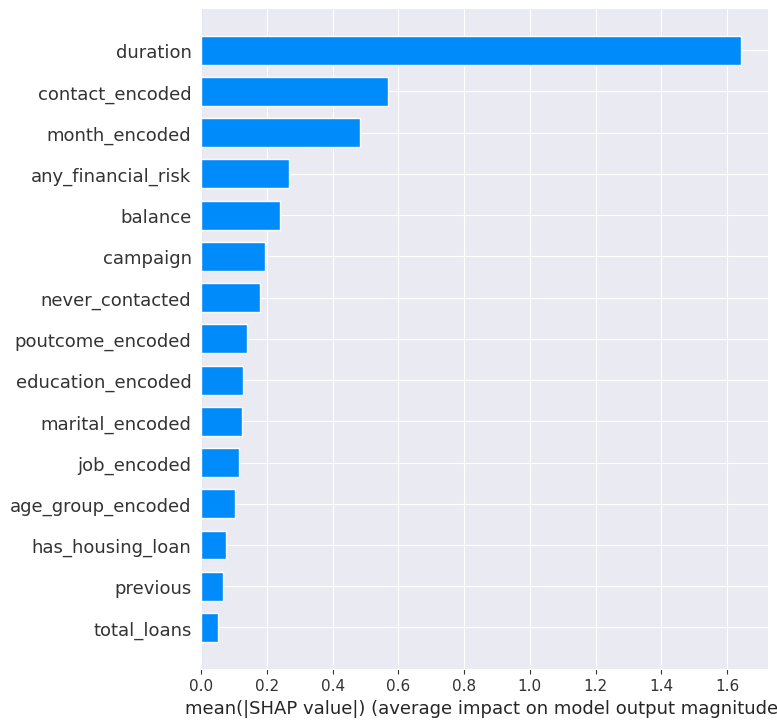

In [128]:
# Summary plot
shap.summary_plot(shap_values,X_test, feature_names=X.columns, plot_type='bar', max_display=15)

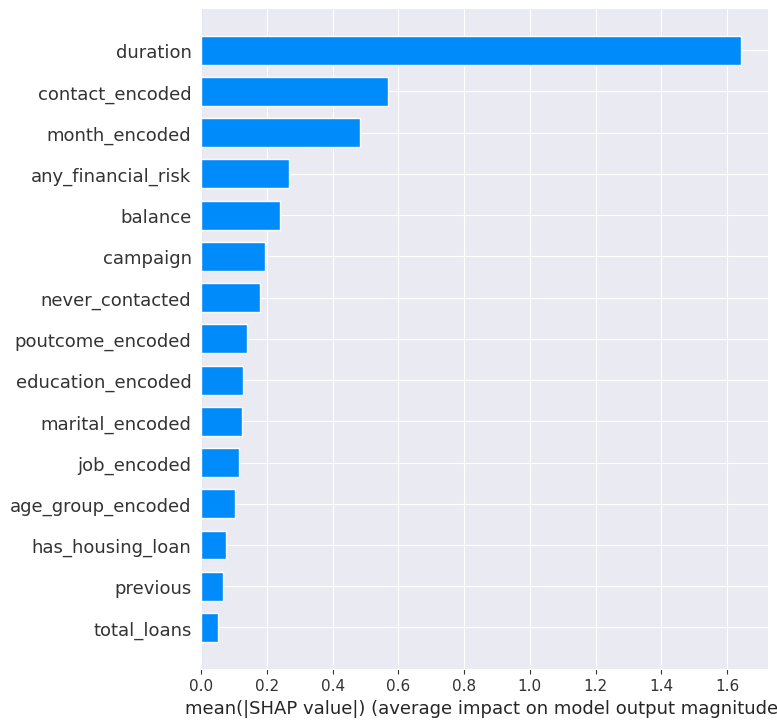

In [130]:
# Summary plot for subscribers
shap.summary_plot(shap_values,X_test, feature_names=X.columns, plot_type='bar', max_display=15, class_inds=1)

In [118]:
model_filename = 'model_xgboost.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(xgb_model, model_file)


# Key Findings and Insights<a id='es'></a>




1. There are statistical significant for the status of default, housing and personal loan. Clients without mortgages are more than **2x as likely** to subscribe (16.7% vs 7.7%). Also clients with financial commitment (without loan default are also **2x as likely** to subscribe

2. Clients with finanacial profile **(No_Mortgage_no_no)** have hightest success rate of **18%**of subcription to deposit term.

3. The number of financial product such as mortage, personal loan and loan default decrease the success rate of subcription.

4. Previous success clients have success subcription rate of  64%

5. Best recontact timing for previous success: **(365.0, 730.0 days)** and it decrease from **(365.0, 730.0)** to **31-90 days**

6. Best recontact days for highest success subcription rate is within **31-90 days**

7. Age: Clients in age group Baby Boomers (60+), Gen Z (18-27) and Millennials (28-43) are more receptive.

8. Job: Student has high subcription rate as compared to other job category followed by retired group

9. Education and Marital: More focus should be on tertiary and single group

10. Boomers with tertiary education level has highest rate through combination of age group and education level

11. Boomers who are divorced has hightest rate comparing age group and marital status

12. Single student group and divorced retired has higher rate of 29% and 28% respectively comparing job and marital statuse

13. The subscription has higher average call durations of 465 second.

14. General importance feature that has higher impact on the predictability of subcriptions are duration, balance  month, campaign and job
.


# Term Deposit Campaign Recommendations

## Executive Summary
Analysis reveals clear targeting opportunities with subscription rates varying from 7.7% to 64% across different client segments. Key recommendation: prioritize high-value segments and optimize contact timing.

## Priority Target Segments

### **Highest Priority (18-29% success rates)**
- **Primary**: Clients with no mortgage, personal loans, or defaults (18% success rate)
- **Student segment**: Single students (29% success rate)
- **Retiree segment**: Divorced retirees (28% success rate)
- **Previous successful clients**: Within 1-2 year window (64% success rate)

### **Secondary Priority (Above average rates)**
- Baby Boomers (60+) with tertiary education
- Gen Z (18-27) and Millennials (28-43)
- Divorced Baby Boomers
- Tertiary-educated, single clients

## Contact Strategy

### **Timing Optimization**
- **Previous clients**: Recontact between 365-730 days after last success
- **New prospects**: Contact within 31-90 days of initial outreach
- **Call duration**: Target 7-8 minute conversations (465+ seconds correlate with success)

### **Avoid/Deprioritize**
- Clients with multiple financial products (mortgages, personal loans)
- Clients with loan defaults (50% lower success rates)

## Campaign Execution

**Phase 1**: Target no-mortgage clients and previous successful clients within optimal timing windows
**Phase 2**: Focus on student and retiree segments with demographic overlays
**Phase 3**: Expand to secondary priority segments based on Phase 1-2 performance

**Expected Impact**: 2-3x improvement in conversion rates by focusing resources on identified high-success segments.

# Reference <a id ='r'></a>

* [SHAP Documentation](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html)

* [Claude Prompt](https://claude.ai/public/artifacts/745ea4eb-26d9-4bad-a458-cce3addc9d9c)

* [Pandas](https://pandas.pydata.org/docs/)

* [Numpy](https://numpy.org/doc/)

* [Scikit-learn](https://scikit-learn.org/0.21/documentation.html)

* [Scikit-learn](https://scikit-learn.org/0.21/documentation.html)